# Codestates Project 2 - Data Science Field Salary

질문. 나와 동기들의 10년뒤 연봉은 얼마나 될까?

Dataset : data_0_Levels_Fyi_Salary_Data.csv  
From : https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries  

Features
- timestamp : 기록시간인듯?
- company : 회사 1632개
- level : 직급인듯? (약 3000)
- title : 하는일
- totalyearlycompensation : 총급여
- location : 위치
- years of experience : 경력
- years at company : 근속연수
- tag : 하는일
- basesalary : 기본급여
- stock grant value : 스톡옵션
- bonus : 보너스
- gender : 성별
- cityid : 도시번호?
- dmaid : media market, 지역분할 방식인듯?
- degree : 학위
- race : 인종  
       [nan, 'White', 'Asian', 'Black', 'Two Or More', 'Hispanic']
- education : 교육  
       [nan, 'PhD', "Master's Degree", "Bachelor's Degree", 'Some College', 'Highschool']

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

import category_encoders

from lightgbm import LGBMRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 30)


In [8]:
df_0 = pd.read_csv("data_0_Levels_Fyi_Salary_Data.csv")
print(df_0.shape)
df_0.head(5).T

(62642, 29)


,0,1,2,3,4
timestamp,6/7/2017 11:33:27,6/10/2017 17:11:29,6/11/2017 14:53:57,6/17/2017 0:23:14,6/20/2017 10:58:51
company,Oracle,eBay,Amazon,Apple,Microsoft
level,L3,SE 2,L7,M1,60
title,Product Manager,Software Engineer,Product Manager,Software Engineering Manager,Software Engineer
totalyearlycompensation,127000,100000,310000,372000,157000
location,"Redwood City, CA","San Francisco, CA","Seattle, WA","Sunnyvale, CA","Mountain View, CA"
yearsofexperience,1.5,5.0,8.0,7.0,5.0
yearsatcompany,1.5,3.0,0.0,5.0,3.0
tag,NaN,NaN,NaN,NaN,NaN
basesalary,107000.0,0.0,155000.0,157000.0,0.0


In [9]:
# drop unsued
df_0 = df_0.drop(["otherdetails", "dmaid", "rowNumber"], axis=1)

# change columns name
df_0 = df_0.rename(
    columns = {"totalyearlycompensation":"annual_income",
               "yearsofexperience":"years_of_experience"},
    )

# set target
target = "annual_income"

<AxesSubplot:>

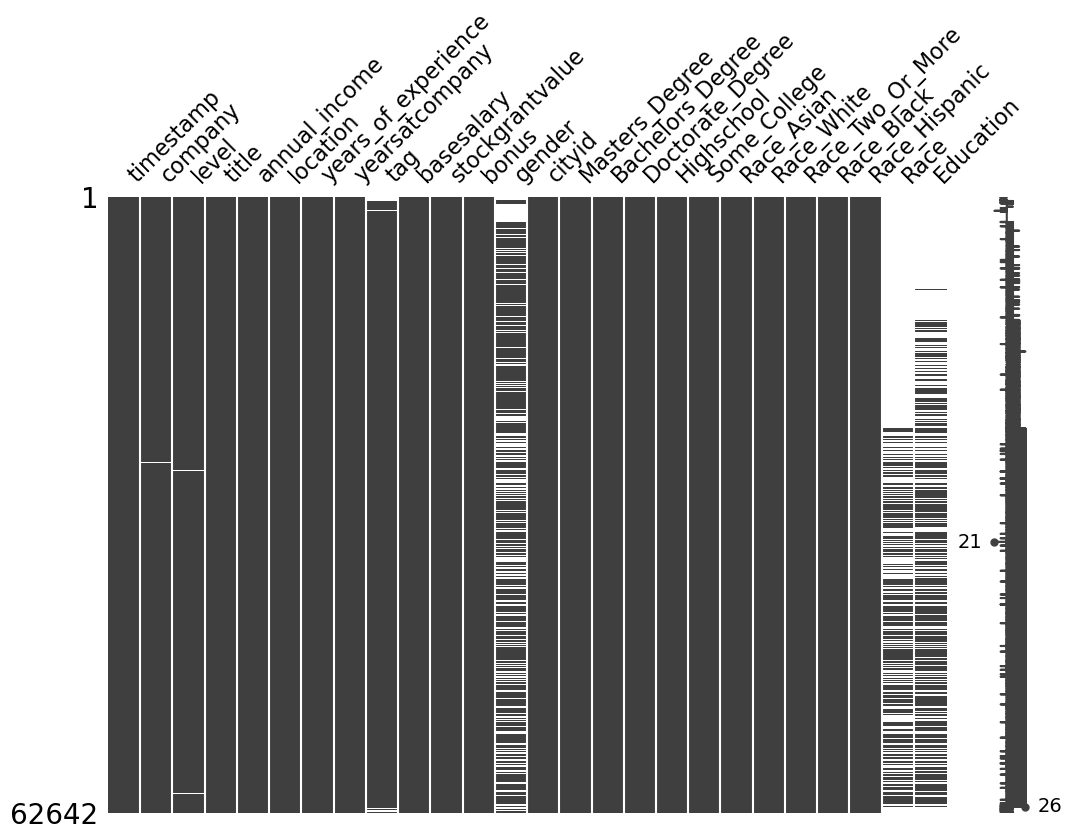

In [10]:
# check missing values
msno.matrix(df_0, figsize=(12, 8))

In [11]:
# 결측치 처리
df_0.isna().sum()
# company : drop
df_0_cln = df_0.dropna(subset="company")

# tag, gender : nan -> no_answer
nan_cols = ["tag", "gender", "Race", "Education", "level"]
df_0_cln[nan_cols] = df_0_cln[nan_cols].fillna("no_answer")

# 
df_0_cln.isna().sum()

C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\2125687911.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0_cln[nan_cols] = df_0_cln[nan_cols].fillna("no_answer")


timestamp              0
company                0
level                  0
title                  0
annual_income          0
location               0
years_of_experience    0
yearsatcompany         0
tag                    0
basesalary             0
stockgrantvalue        0
bonus                  0
gender                 0
cityid                 0
Masters_Degree         0
Bachelors_Degree       0
Doctorate_Degree       0
Highschool             0
Some_College           0
Race_Asian             0
Race_White             0
Race_Two_Or_More       0
Race_Black             0
Race_Hispanic          0
Race                   0
Education              0
dtype: int64

In [12]:
# 이상치 처리
# df_0_cln[df_0_cln.gender == 'Title: Senior Software Engineer'].T
df_0_cln.at[11010,"gender"] = "no_answer"
df_0_cln.gender.unique()


array(['no_answer', 'Male', 'Female', 'Other'], dtype=object)

0.0 3.0 6.0 10.0 69.0
-1.5 25.0


<AxesSubplot:>

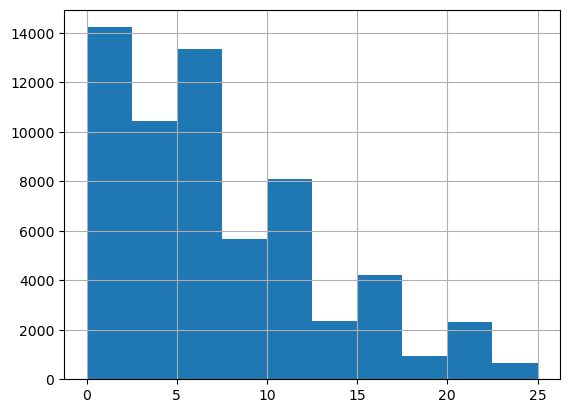

In [13]:
# clear outlier

q0 = df_0_cln["years_of_experience"].quantile(q=0)
q1 = df_0_cln["years_of_experience"].quantile(q=0.25)
q2 = df_0_cln["years_of_experience"].quantile(q=0.5)
q3 = df_0_cln["years_of_experience"].quantile(q=0.75)
q4 = df_0_cln["years_of_experience"].quantile(q=1)

print(q0, q1, q2, q3, q4)
min = q1 - (1.5 * q1)
max = q3 + (1.5 * q3)
print(min, max)

df_0_cln = df_0_cln[df_0_cln.years_of_experience <= (max)]
df_0_cln.years_of_experience.hist()

In [14]:
# feature engineering
from unicodedata import category


def feature_engineering(df):

    # 날짜 분리
    df.timestamp = pd.to_datetime(df.timestamp)
    df["year"] = df["timestamp"].dt.year
    df["date"] = df["timestamp"].dt.date.astype(str)
    df["date"] = df["date"].str.replace("-","").astype(int)

    # 직무 관련 특성 생성
    ml = df.tag.str.contains("(?i)ml")
    machine = df.tag.str.contains("(?i)machine") & ~df.tag.str.contains("Machine Vision")
    data_woker = df.title == "Data Scientist"
    software_engineer = df.title == "Software Engineer"
    software_enginerr_mng = df.title == "Software Engineering Manager"
    abt_data = df.tag.str.contains("(?i)data")
    data_scientist = ((df.tag.str.contains("(?i)data science")) | (df.tag.str.contains("(?i)data scientist")))

    df["developer"]       = data_woker | software_engineer | software_enginerr_mng
    df["data_woker"]      = data_woker
    df["machin_learning"] = ml | machine
    df["ai"]              = df.tag.str.contains("(?i)ai") & ~df.tag.str.contains("(?i)ai[a-z]")
    df["data_analytics"]  = df.tag.str.contains("(?i)anal") & data_woker
    df["data_scientist"]  = data_scientist
    df["data_engineer"]   = df.tag.str.contains("(?i)data engineer")
    df["data_area"]       = (
        (abt_data & data_woker)
        | (abt_data & software_engineer)
        | (abt_data & software_enginerr_mng)
        | (df["machin_learning"])
        | (df["ai"])
        | (df["data_analytics"])
        | (df["data_scientist"])
        | (df["data_engineer"])
    )

    df["ios"] = df.tag.str.contains("(?i)ios")
    df["android"] = df.tag.str.contains("(?i)android")

    # 지역 데이터 분리
    temp = df.location.str.split(pat=", ", n=2, expand=True)
    df["city"] = temp[0]
    df["state"] = temp[1]
    countries = []
    for i in temp.index:
        country = temp.at[i, 2]
        countries.append(("U.S." if pd.isna(country) else country))
    df["country"] = countries
  
    # Drop columns
    drop_cols = [
        "timestamp",
        "Masters_Degree",
        "Bachelors_Degree",
        "Doctorate_Degree",
        "Highschool",
        "Some_College",
        "Race",
        "location",
    ]
    df = df.drop(drop_cols, axis=1)

    return df


df_0_eng = feature_engineering(df_0_cln.copy())


In [15]:
# 표본이 적은 나라는 제거
# 표본이 많은 상위 20개국 + 한국

countries = df_0_eng["country"].value_counts()[:15].index.to_list()
countries.append("Korea, South")
countries.append("Japan")
countries.append("China")
countries

df_0_flt = df_0_eng[df_0_eng["country"].isin(countries)]

In [16]:
def column_avg(df, col, agg="mean", orient="v"):
    temp = df[[col,target]]
    if agg == "mean":
        temp = temp.groupby(col).agg(np.mean)
    elif agg == "median":
        temp = temp.groupby(col).agg(np.median)
    temp = temp.reset_index(col)
    temp = temp.sort_values(target,ascending=False)
    print(temp.annual_income.values.round(0))
    plt.close("all")
    plt.figure(figsize=(8,8), dpi=300)
    
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    palette = "mako"
    
    if(orient == "v"):
        sns.barplot(data=temp,x=col,y=target, orient=orient, palette=palette)
        
        # put comma
        current_values = plt.gca().get_yticks()
        plt.gca().set_yticklabels([format(int(x),',') for x in current_values])
        
    else :
        sns.barplot(data=temp,x=target,y=col, orient=orient, palette=palette)
        
        # put comma
        current_values = plt.gca().get_xticks()
        plt.gca().set_xticklabels([format(int(x),',') for x in current_values])
        

[252205. 234551. 176747. 160638. 155900. 145038. 139685. 138576. 138095.
 132380. 127083. 121970. 113546.  82830.  76900.  62695.  59773.]


C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\308119836.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([format(int(x),',') for x in current_values])


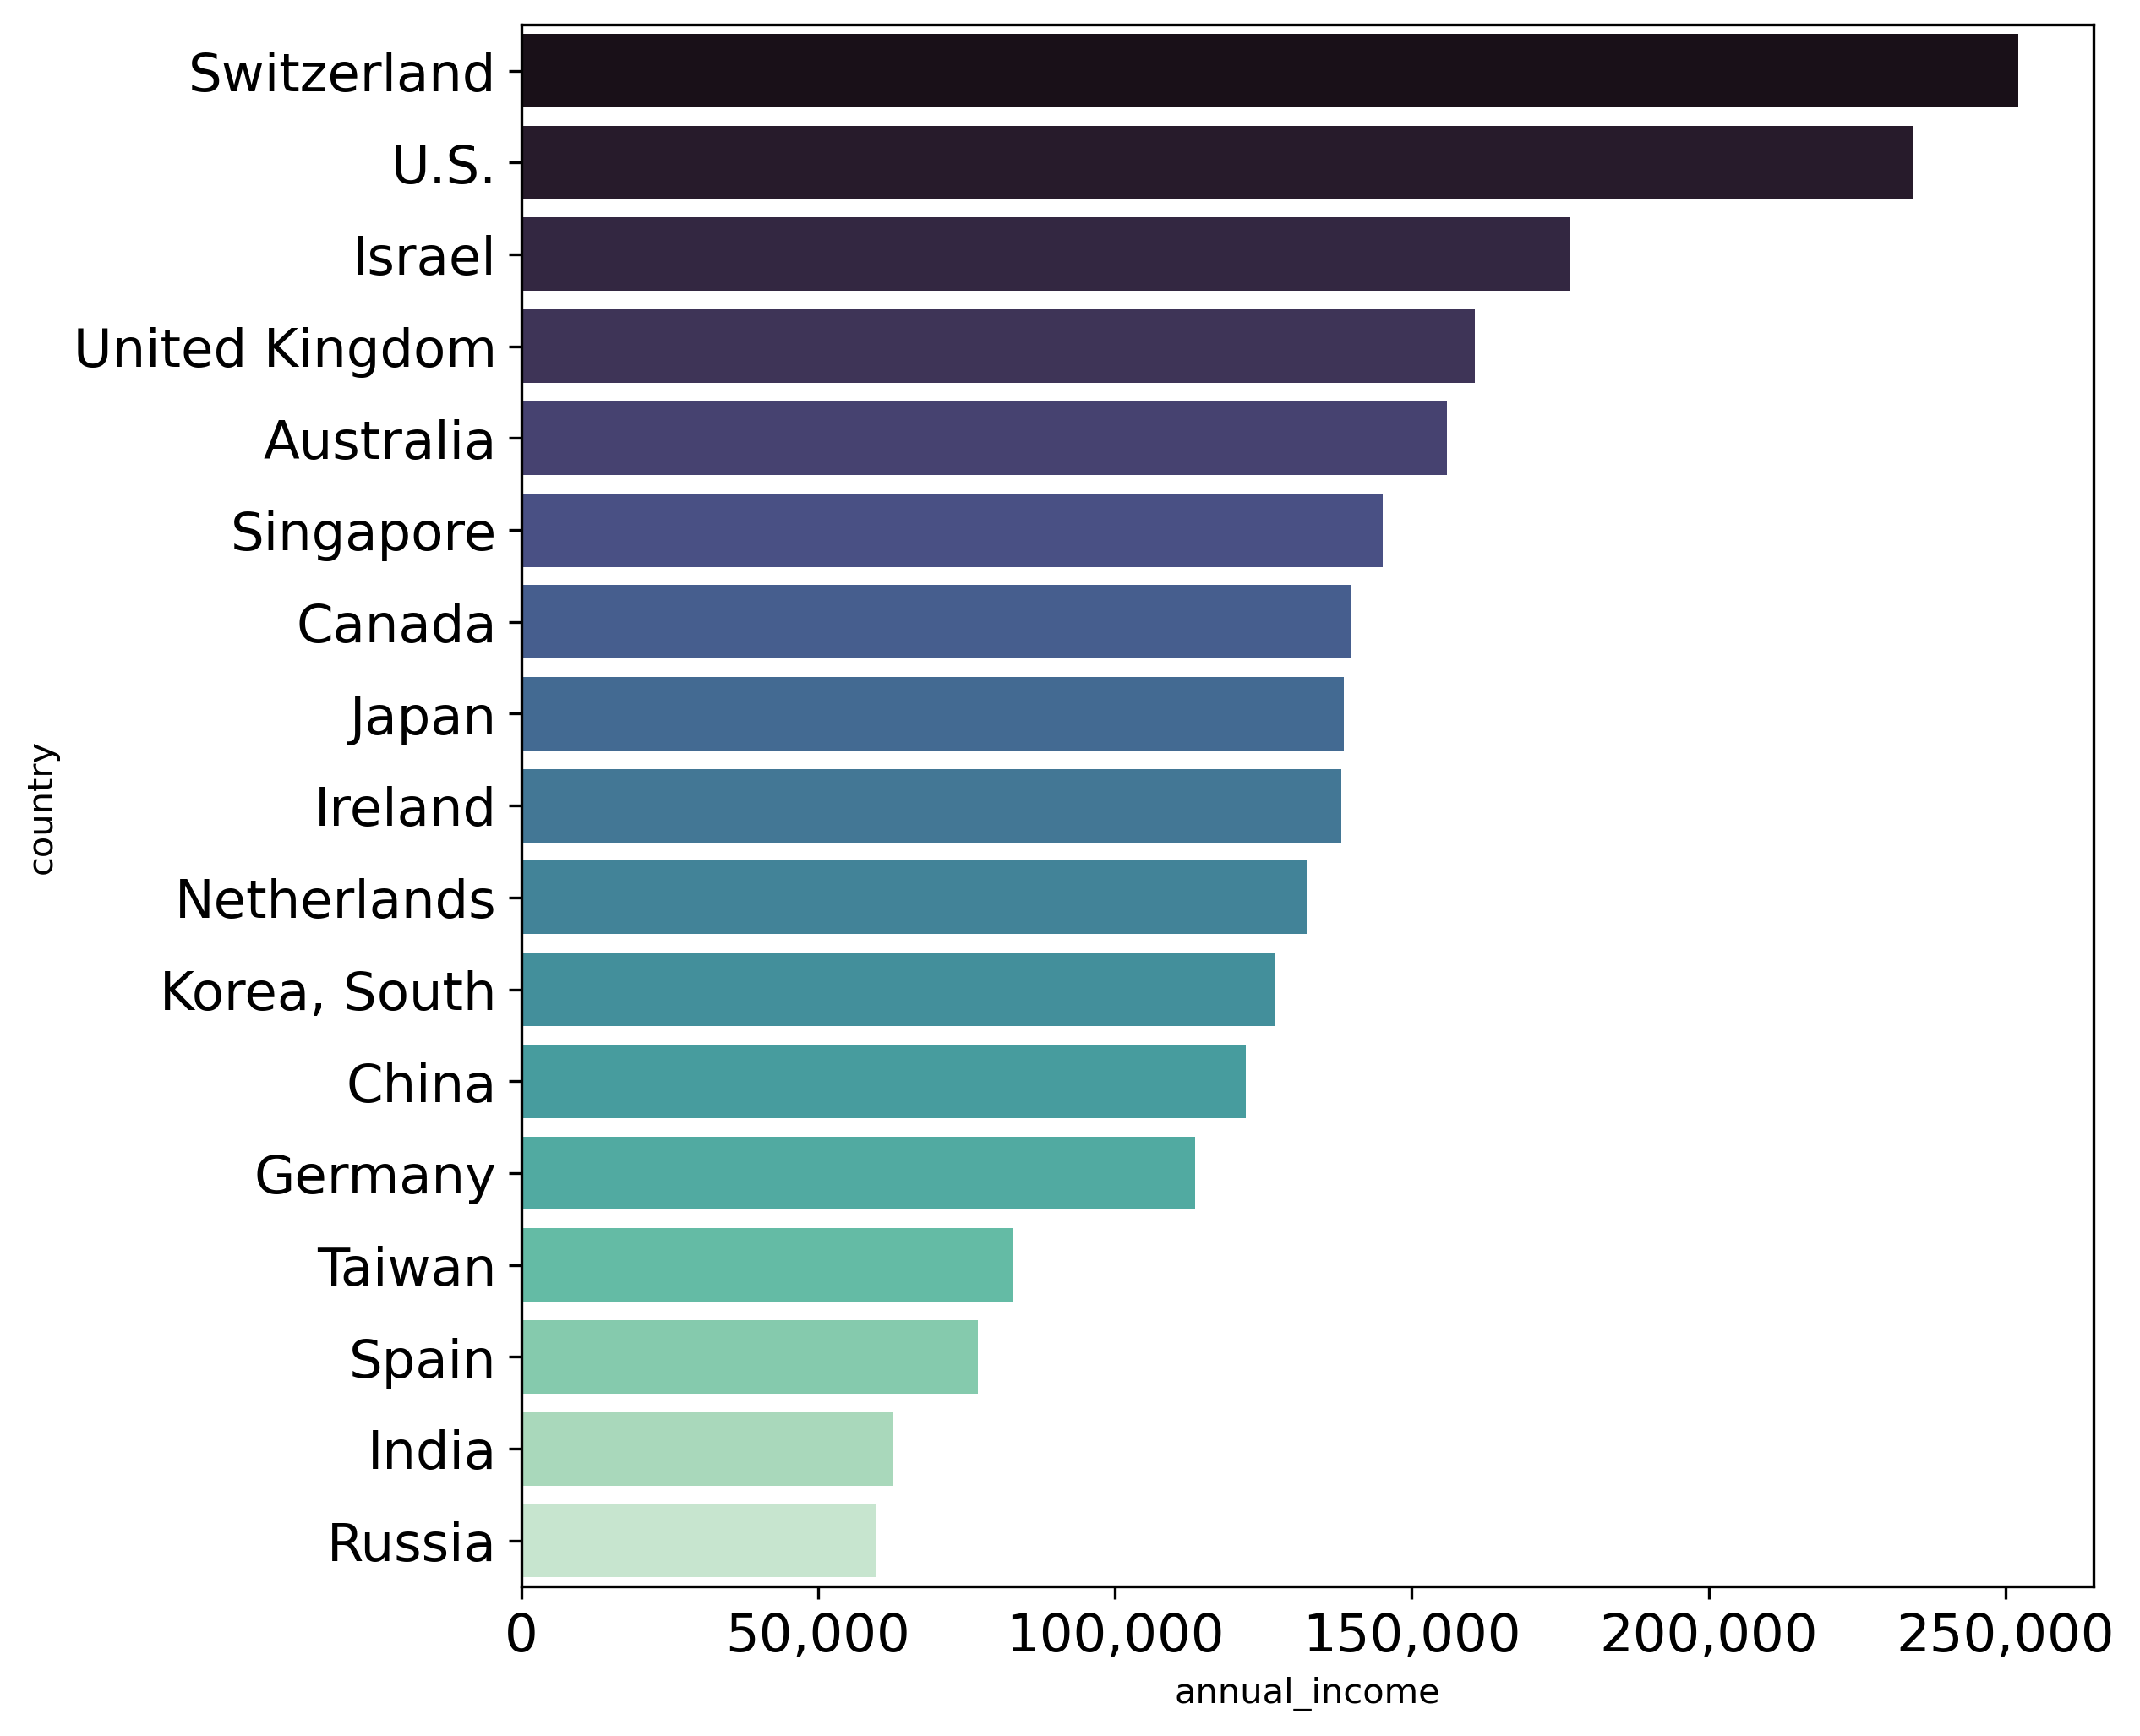

In [17]:
column_avg(df=df_0_flt.copy(), col="country",orient="h")

In [18]:
# top10 company
companies = df_0_flt["company"].value_counts()[:50].index
temp = df_0_flt[df_0_flt["company"].isin(companies)]
temp = temp[["company",target]]
temp = temp.groupby("company").agg(np.mean)
temp = temp.reset_index()
temp = temp.sort_values(by=target,ascending=False)[:10]
temp


,company,annual_income
25,Netflix,481376.865672
34,Snap,411166.666667
23,Lyft,368501.557632
37,Stripe,365552.325581
2,Airbnb,363039.301310
14,Facebook,343206.565657
12,Dropbox,338722.222222
39,Twitter,314812.182741
22,LinkedIn,307005.714286
40,Uber,305847.575058


C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\3895788089.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([format(int(x),',') for x in current_values])


[Text(0.0, 0, '0'),
 Text(100000.0, 0, '100,000'),
 Text(200000.0, 0, '200,000'),
 Text(300000.0, 0, '300,000'),
 Text(400000.0, 0, '400,000'),
 Text(500000.0, 0, '500,000'),
 Text(600000.0, 0, '600,000')]

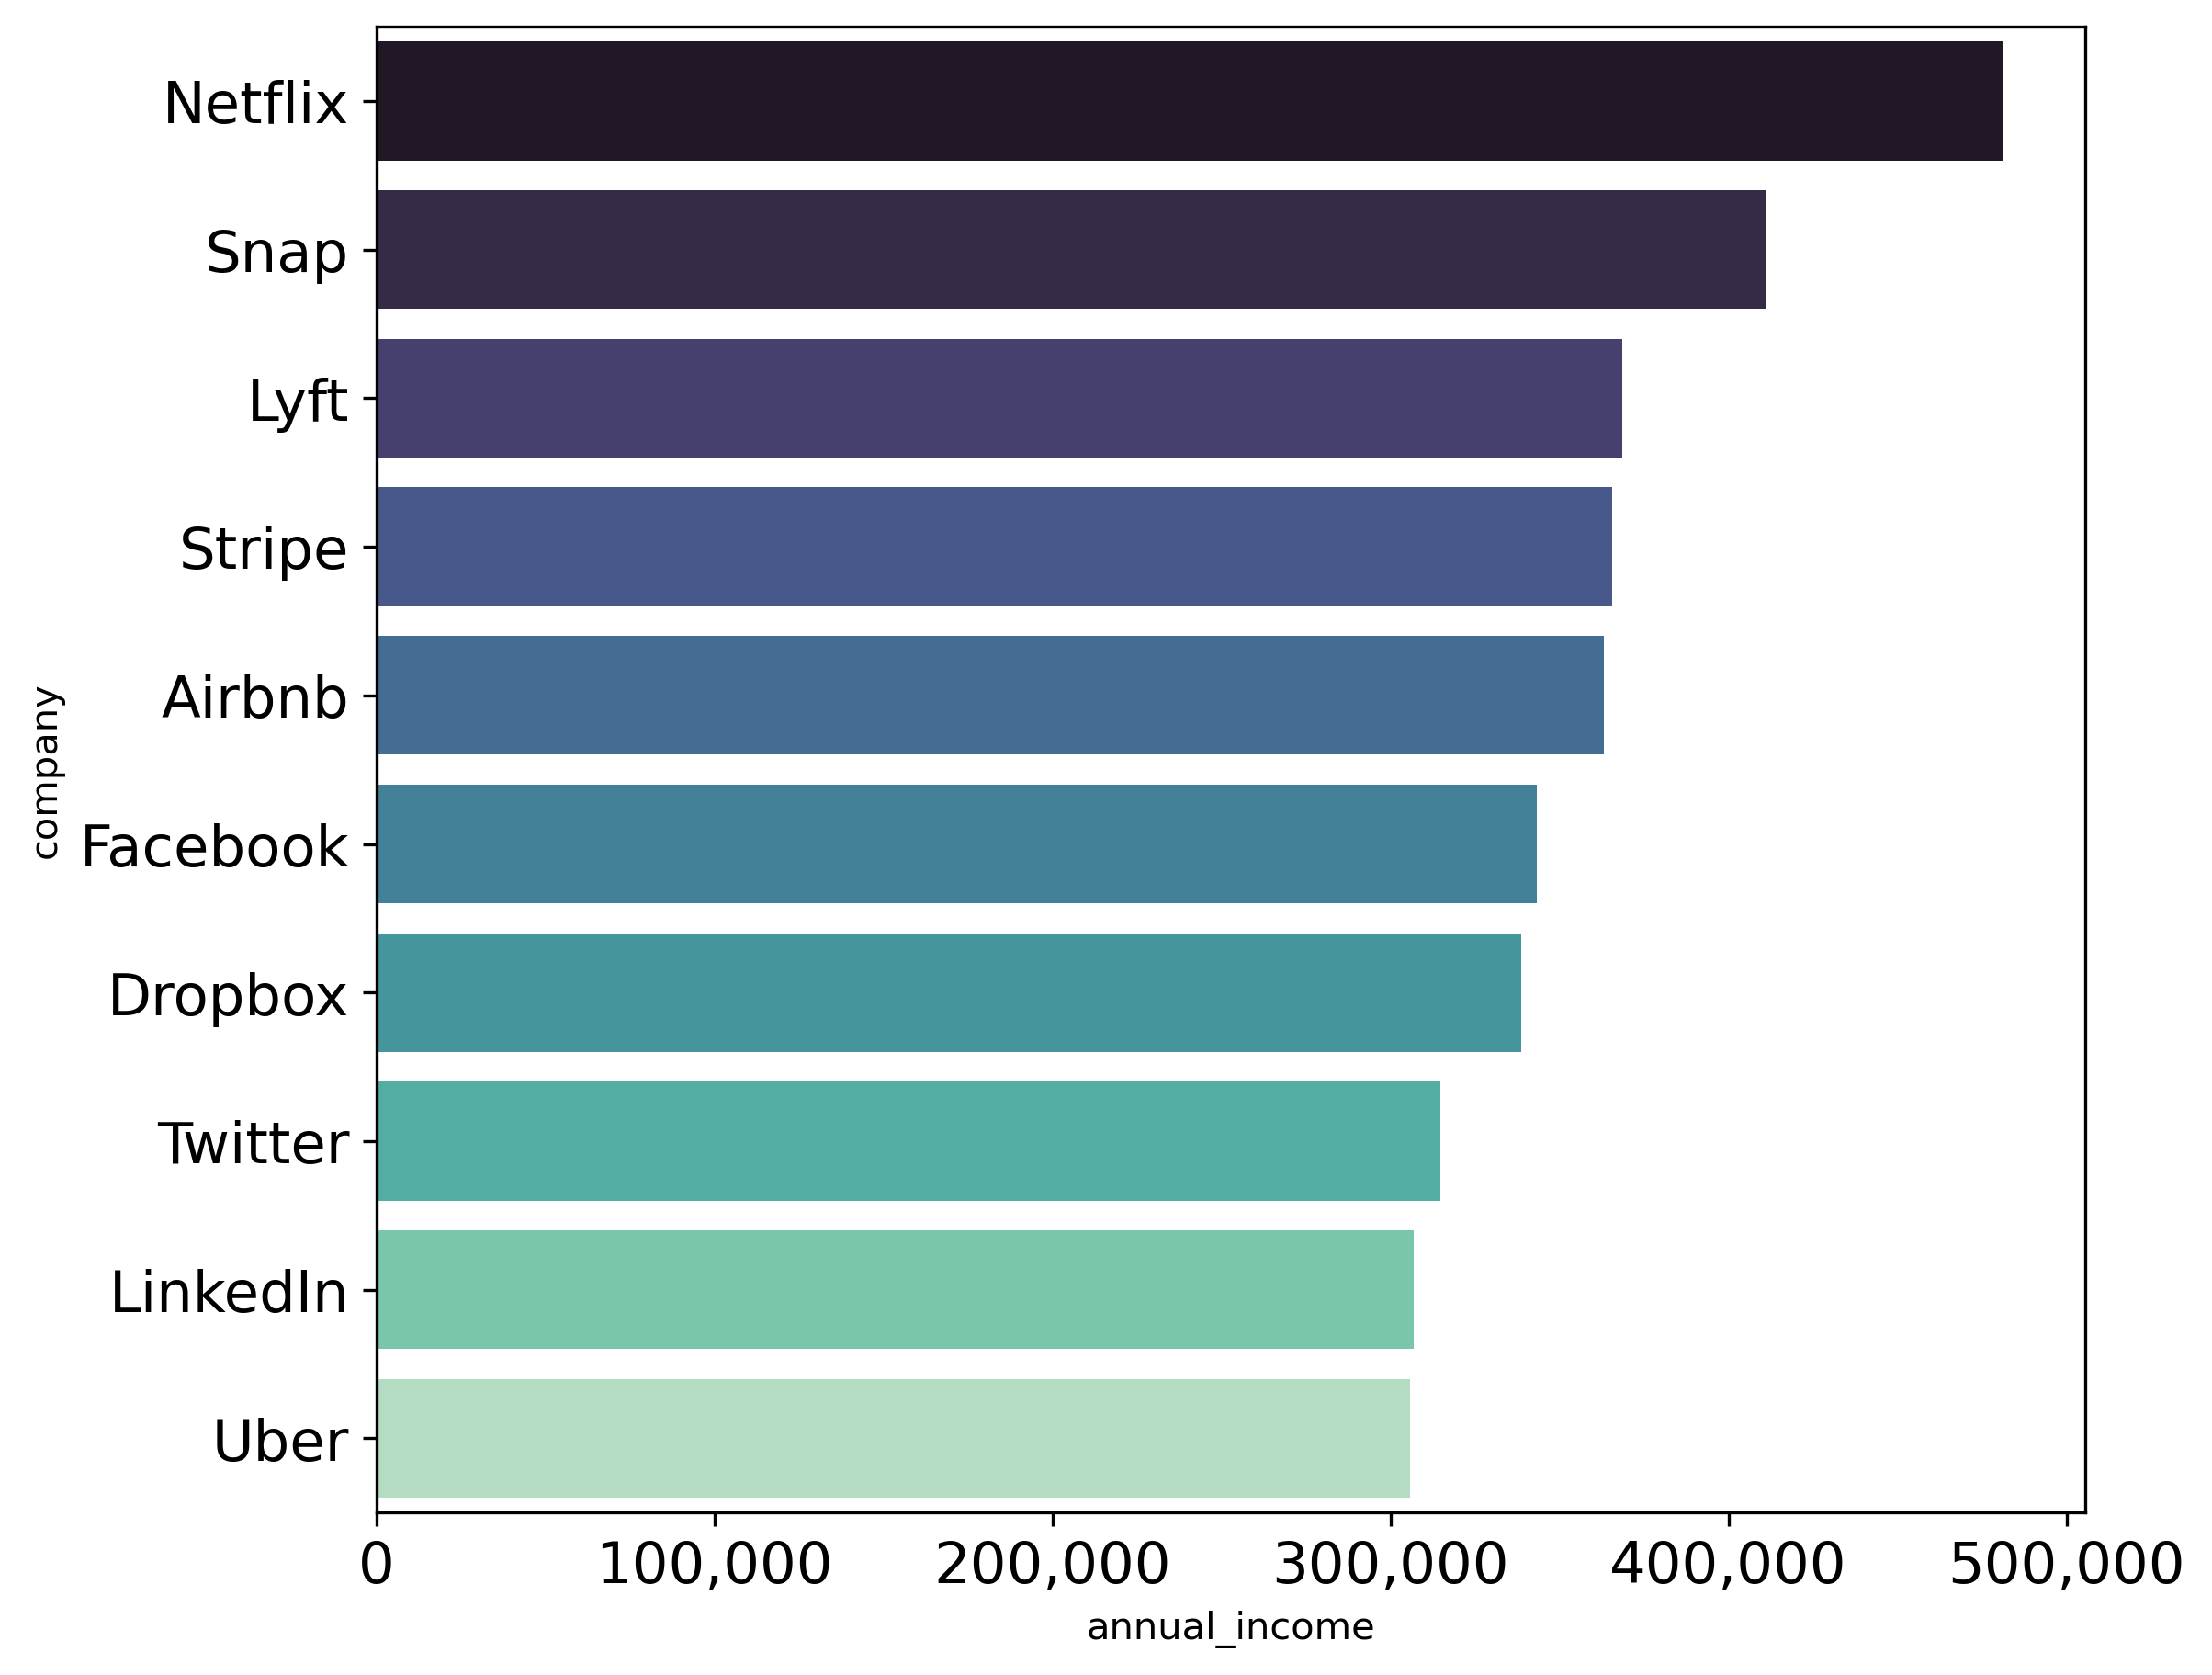

In [19]:
    plt.close("all")
    plt.figure(figsize=(8,7), dpi=300)

    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    palette = "mako"
    
    sns.barplot(data=temp,x=target,y="company", orient="h", palette=palette)
        
    # put comma
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels([format(int(x),',') for x in current_values])

In [20]:
# encoding
# ordinal
df = df_0_flt.copy()

degrees = [
        "no_answer", 
        "Highschool",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "PhD",
    ]
edu_enc = OrdinalEncoder(categories=[degrees])
df[["Education"]] = edu_enc.fit_transform(X=df[["Education"]]).astype(int)


label_cols = [
    "company",
    "title",
    "gender",
    "country",
    "state",
    "city",
    "level",
]
ord_enc = category_encoders.OrdinalEncoder(cols=label_cols)
df[label_cols] = ord_enc.fit_transform(df[label_cols])


df_0_enc = df

In [22]:
# select features

using_features = [
    'company', 
    'level',
    # 'title', 
    'annual_income', 
    'years_of_experience',
    # 'yearsatcompany', 
    # 'tag', 
    # 'basesalary', 
    # 'stockgrantvalue', 
    # 'bonus',
    'gender', 
    # 'cityid', 
    'Race_Asian', 
    'Race_White', 
    'Race_Two_Or_More',
    'Race_Black', 
    'Race_Hispanic', 
    'Education', 
    # "Masters_Degree",
    # "Bachelors_Degree",
    # "Doctorate_Degree",
    # "Highschool",
    # "Some_College",
    'year', 
    # 'date', 
    'developer',
    'data_woker', 
    'machin_learning', 
    'ai', 
    'data_analytics',
    'data_scientist', 
    'data_engineer', 
    'data_area', 
    # 'ios', 
    # 'android',
    'city', 
    # 'state', 
    'country']

df_0_final = df_0_enc[using_features]
# astype
categoricals = ["country","gender","city"]
df_0_final[categoricals] = df_0_final[categoricals].astype("category")

df_0_final.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 61437 entries, 0 to 62641
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   company              61437 non-null  int32   
 1   level                61437 non-null  int32   
 2   annual_income        61437 non-null  int64   
 3   years_of_experience  61437 non-null  float64 
 4   gender               61437 non-null  category
 5   Race_Asian           61437 non-null  int64   
 6   Race_White           61437 non-null  int64   
 7   Race_Two_Or_More     61437 non-null  int64   
 8   Race_Black           61437 non-null  int64   
 9   Race_Hispanic        61437 non-null  int64   
 10  Education            61437 non-null  int32   
 11  year                 61437 non-null  int64   
 12  developer            61437 non-null  bool    
 13  data_woker           61437 non-null  bool    
 14  machin_learning      61437 non-null  bool    
 15  ai                 

C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\350410915.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0_final[categoricals] = df_0_final[categoricals].astype("category")


[217560. 216035.]


C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\308119836.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([format(int(x),',') for x in current_values])


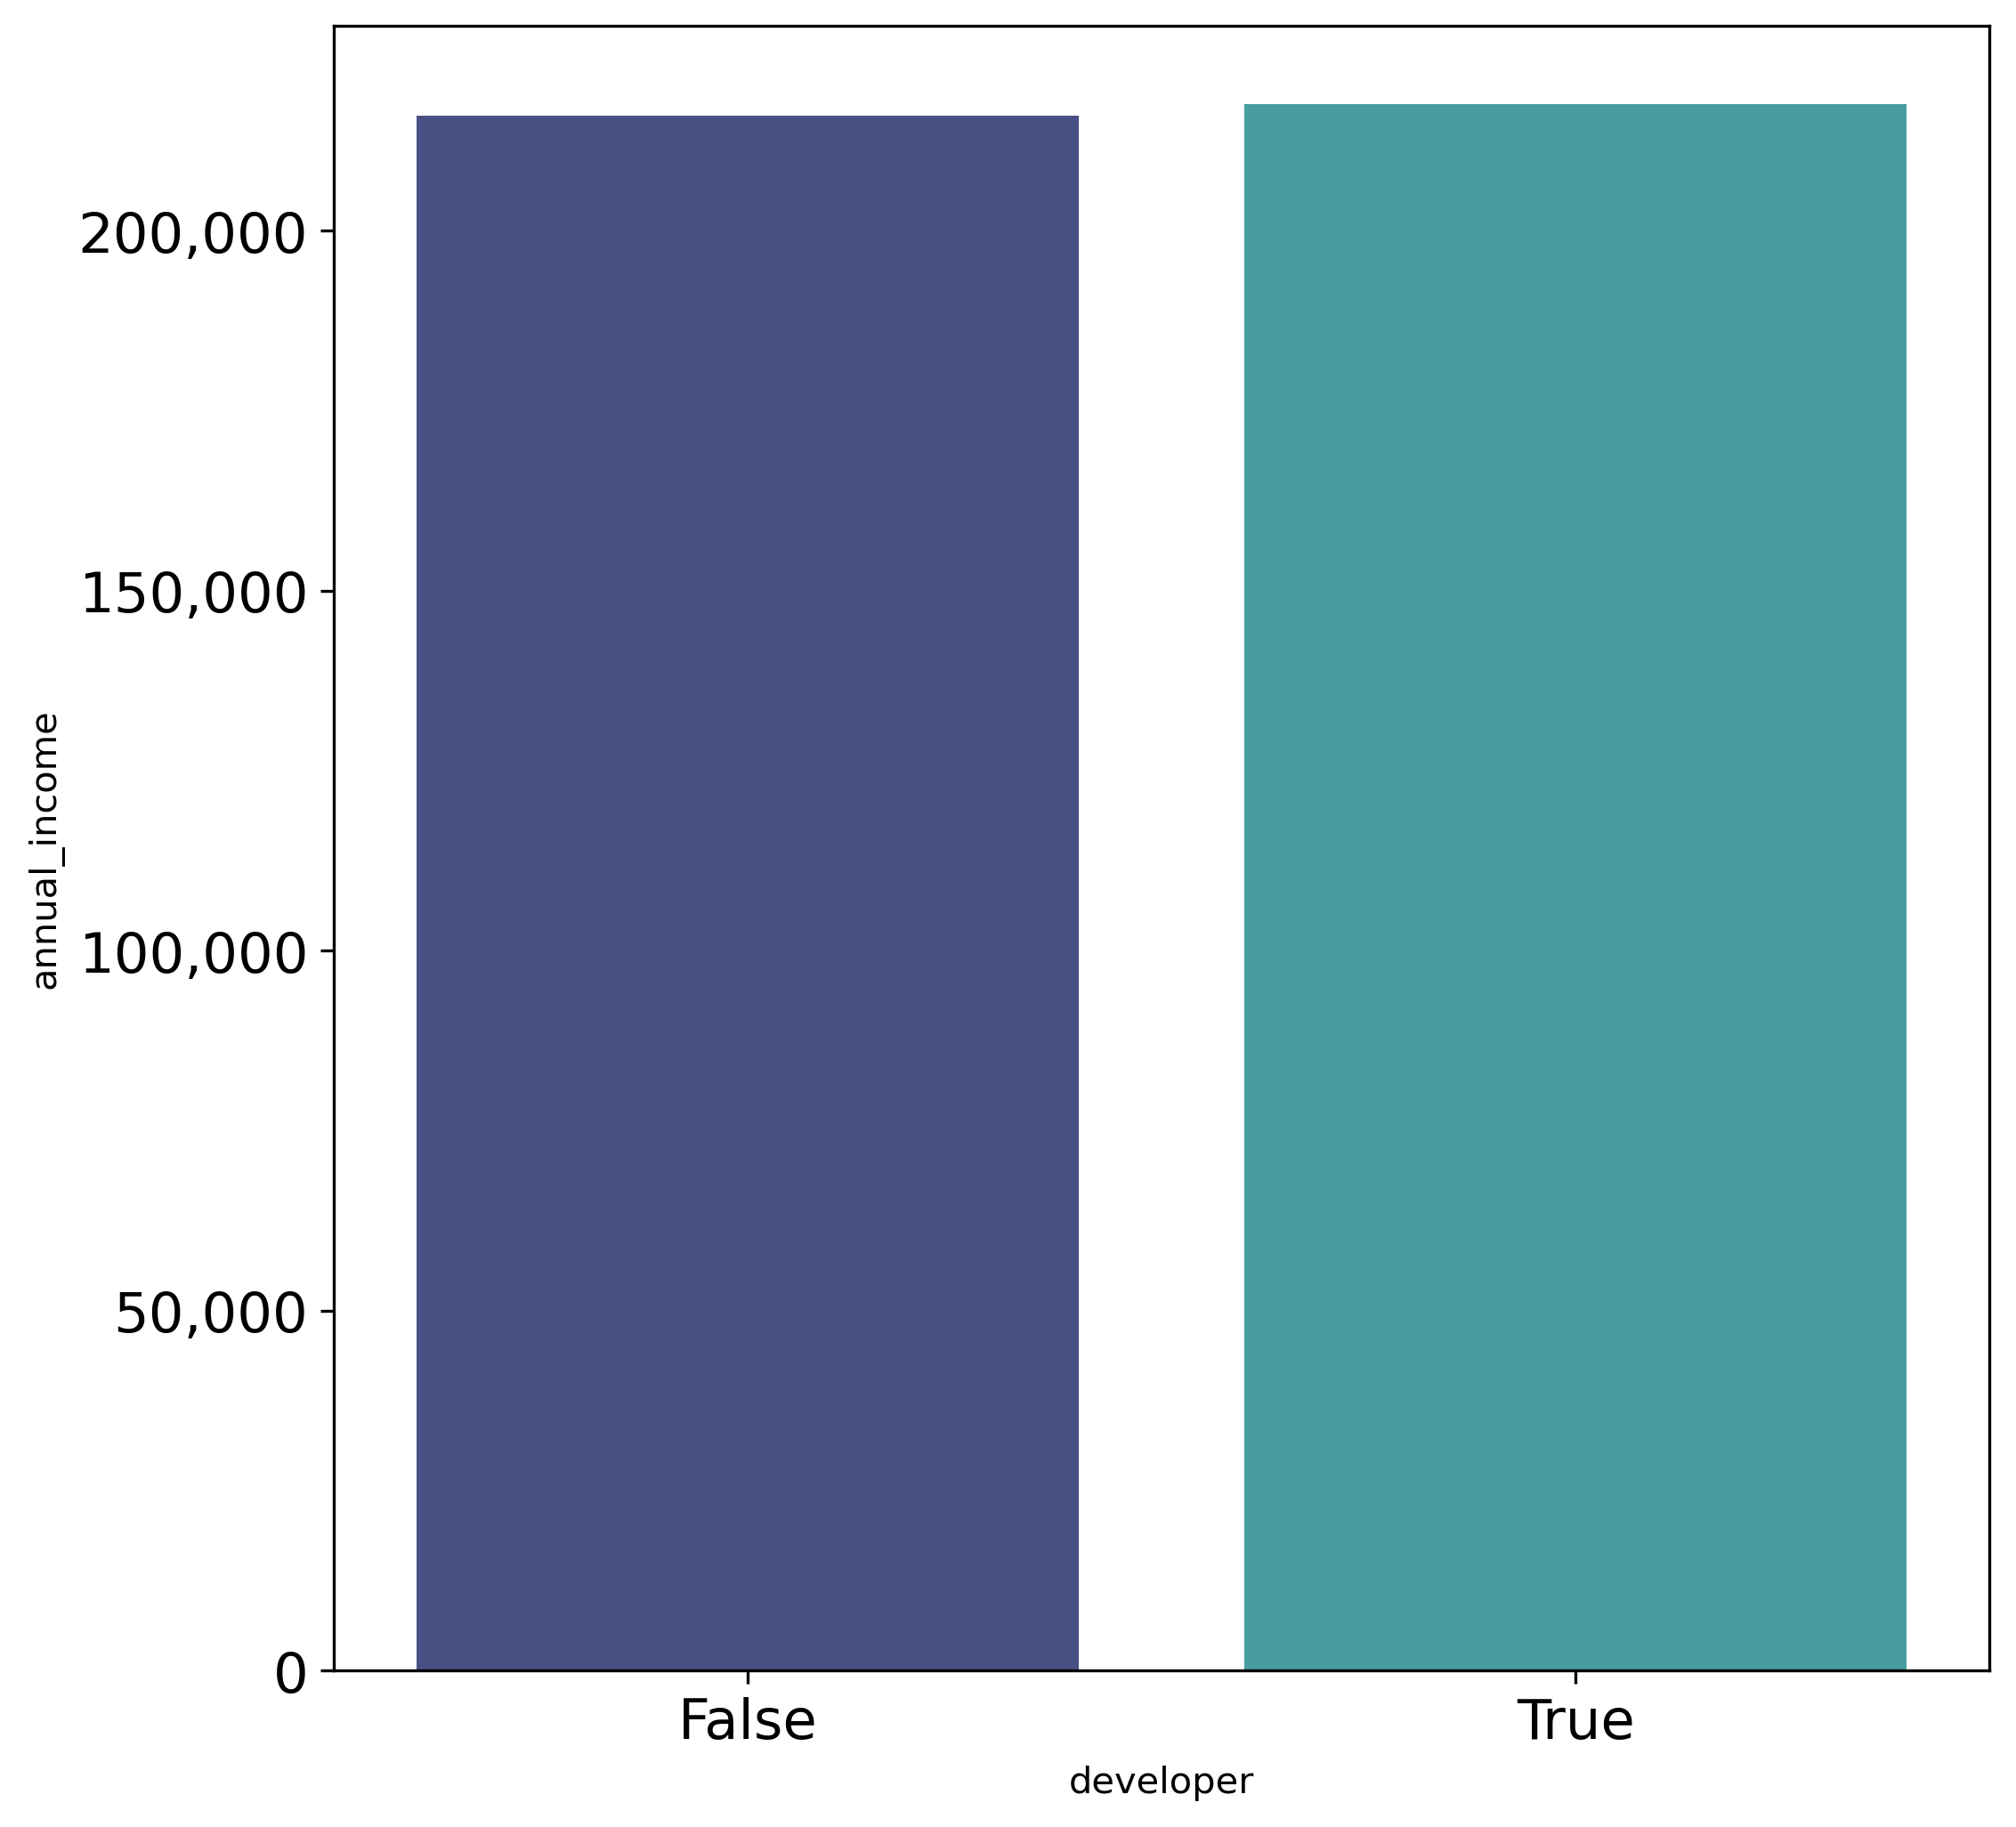

In [23]:
# developer vs non-developer

column_avg(df_0_final.copy(),"developer",agg="mean")

[244150. 214171.]


C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\308119836.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([format(int(x),',') for x in current_values])


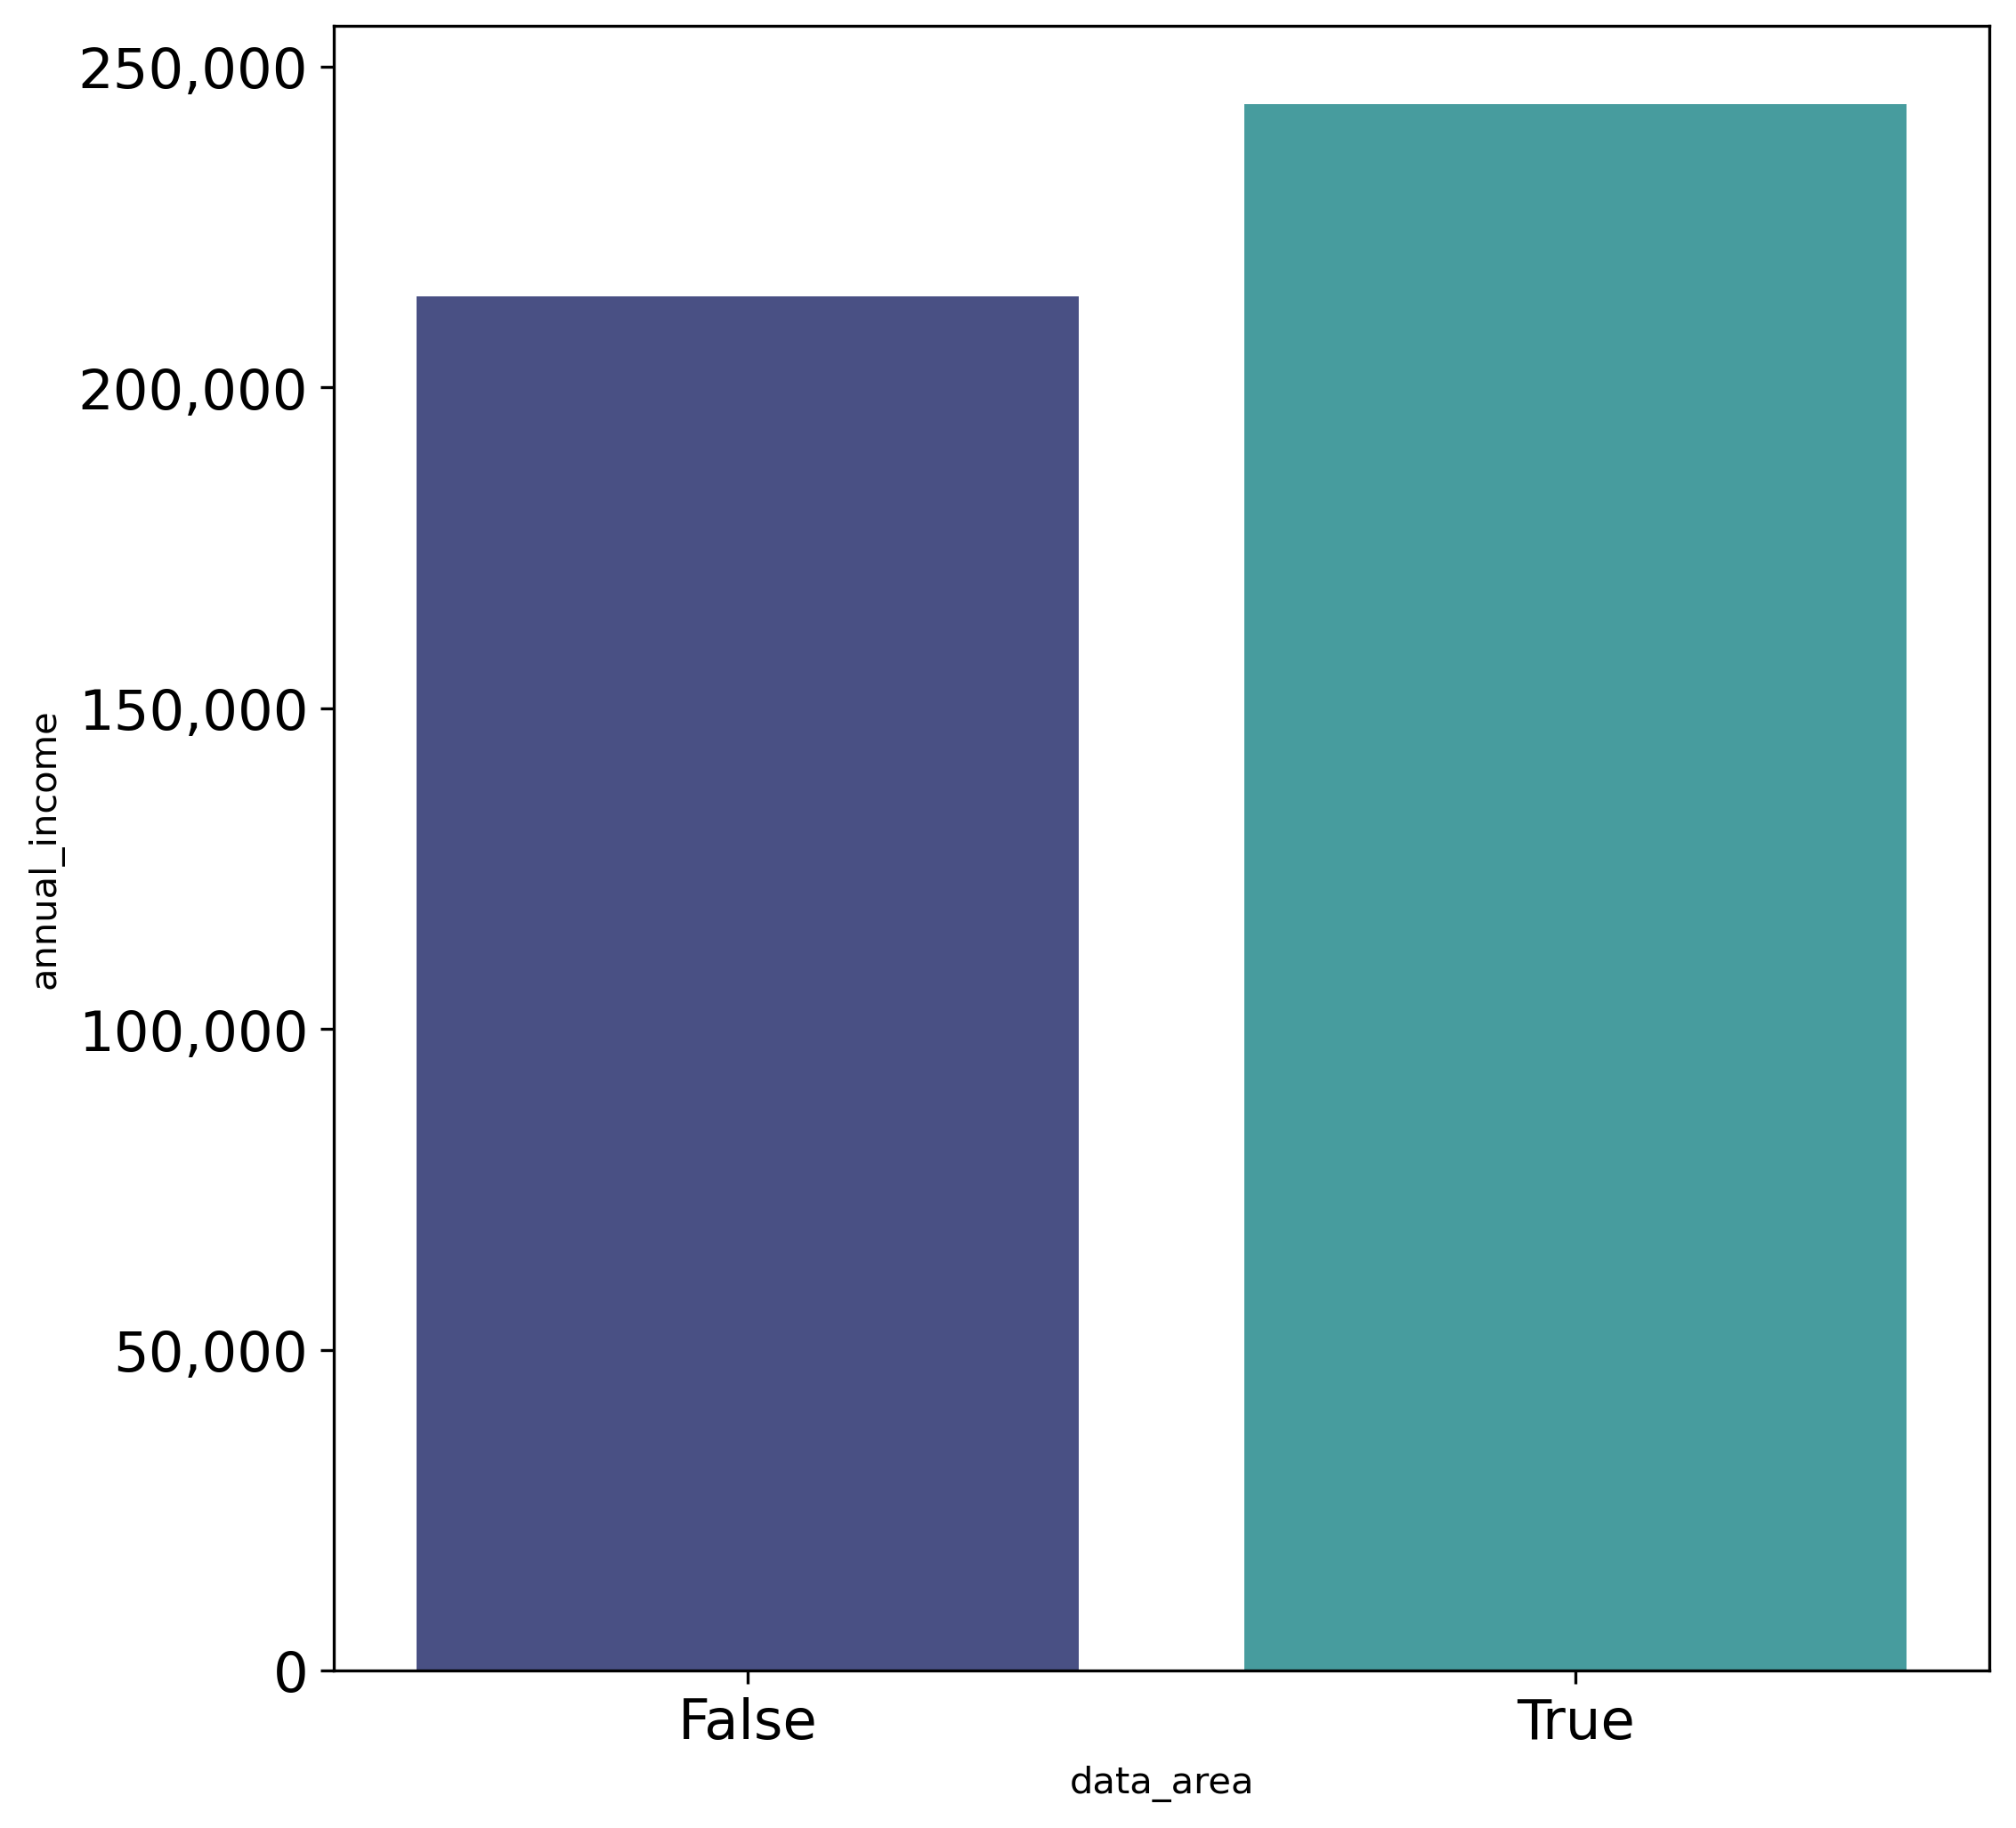

In [25]:
# data area vs non-data area

column_avg(df_0_final.copy(), "data_area")

In [26]:
# seperate train valid test 

tt, test = train_test_split(df_0_final, test_size=0.2, random_state=42)
train, valid = train_test_split(tt, test_size=0.2, random_state=42)

X_tt, y_tt = tt.drop(target, axis=1), tt[target]
X_train, y_train = train.drop(target, axis=1), train[target]
X_valid, y_valid = valid.drop(target, axis=1), valid[target]
X_test, y_test = test.drop(target, axis=1), test[target]

print(X_tt.shape, X_train.shape, X_valid.shape, X_test.shape)

(49149, 21) (39319, 21) (9830, 21) (12288, 21)


In [27]:
# Scaler set
ct = ColumnTransformer([('somename', StandardScaler(), ['years_of_experience'])], remainder='passthrough')

In [28]:
# Linear Regressor

lr_pipe = make_pipeline(
    ct,
    LinearRegression(
        n_jobs=-1,    
    )
)

lr_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('somename', StandardScaler(),
                                                  ['years_of_experience'])])),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [29]:
baseline = lr_pipe.predict(X_valid)
r2_base = r2_score(y_true=y_valid, y_pred=baseline)
r2_base

0.3344811128638383

In [32]:
# Lasso
alphas = np.arange(1, 10, 1)
alphas = [0.000001, 0.001, 0.01, 1.0, 10]
lasso_pipe = make_pipeline(
    ct,
    LassoCV(
        alphas=alphas,
        cv=5
    ),
)
lasso_pipe.fit(X_train, y_train)
model = lasso_pipe.steps[1][1]
print("alpha: ", model.alpha_)

pred_lasso = lasso_pipe.predict(X_valid)
r2_lasso = r2_score(y_true=y_valid, y_pred=pred_lasso)
r2_lasso

alpha:  1e-06


0.3344811128612891

In [33]:
# Ridge
alphas = [0.000001, 0.001, 0.01, 1.0, 10]
ridge_pipe = make_pipeline(
    ct,
    RidgeCV(
        alphas=alphas,
        cv=5
    ),
)
ridge_pipe.fit(X_train, y_train)
model = ridge_pipe.steps[1][1]
print("alpha: ", model.alpha_)

pred_ridge = ridge_pipe.predict(X_valid)
r2_ridge = r2_score(y_true=y_valid, y_pred=pred_ridge)
r2_ridge

alpha:  10.0


0.3344701353813657

In [34]:
# ElasticNet
# alphas = np.arange(1, 10, 1)
alphas = [0.000001, 0.001, 0.01, 1.0, 10]
en_pipe = make_pipeline(
    ct,
    ElasticNetCV(
        alphas=alphas,
        random_state=42,
        n_jobs=-1,
        cv=5,
    )
)
en_pipe.fit(X_train, y_train)
model = en_pipe.steps[1][1]
print("alpha: ", model.alpha_)

pred_en = en_pipe.predict(X_valid)
r2_en = r2_score(y_true=y_valid, y_pred=pred_en)
r2_en

alpha:  0.001


0.3344588635647474

In [35]:
# RandomForestRegressor
rf_pipe = make_pipeline(
    ct,
    RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    )
)

rf_pipe.fit(X_train, y_train)
pred_rf = rf_pipe.predict(X_valid)
r2_rf = r2_score(y_true=y_valid,y_pred=pred_rf)
r2_rf

0.6445263338906733

In [36]:
lgb_pipe = make_pipeline(
    ct,
    LGBMRegressor(
        random_state=42,
        n_jobs=-1,
    ),
)

lgb_pipe.fit(X_train,y_train)
pred_lgb = lgb_pipe.predict(X_valid)
r2_lgb = r2_score(y_true=y_valid,y_pred=pred_lgb)
r2_lgb

0.658029652268295

[0.3344811128638383, 0.3344811128612891, 0.3344701353813657, 0.6445263338906733, 0.658029652268295]


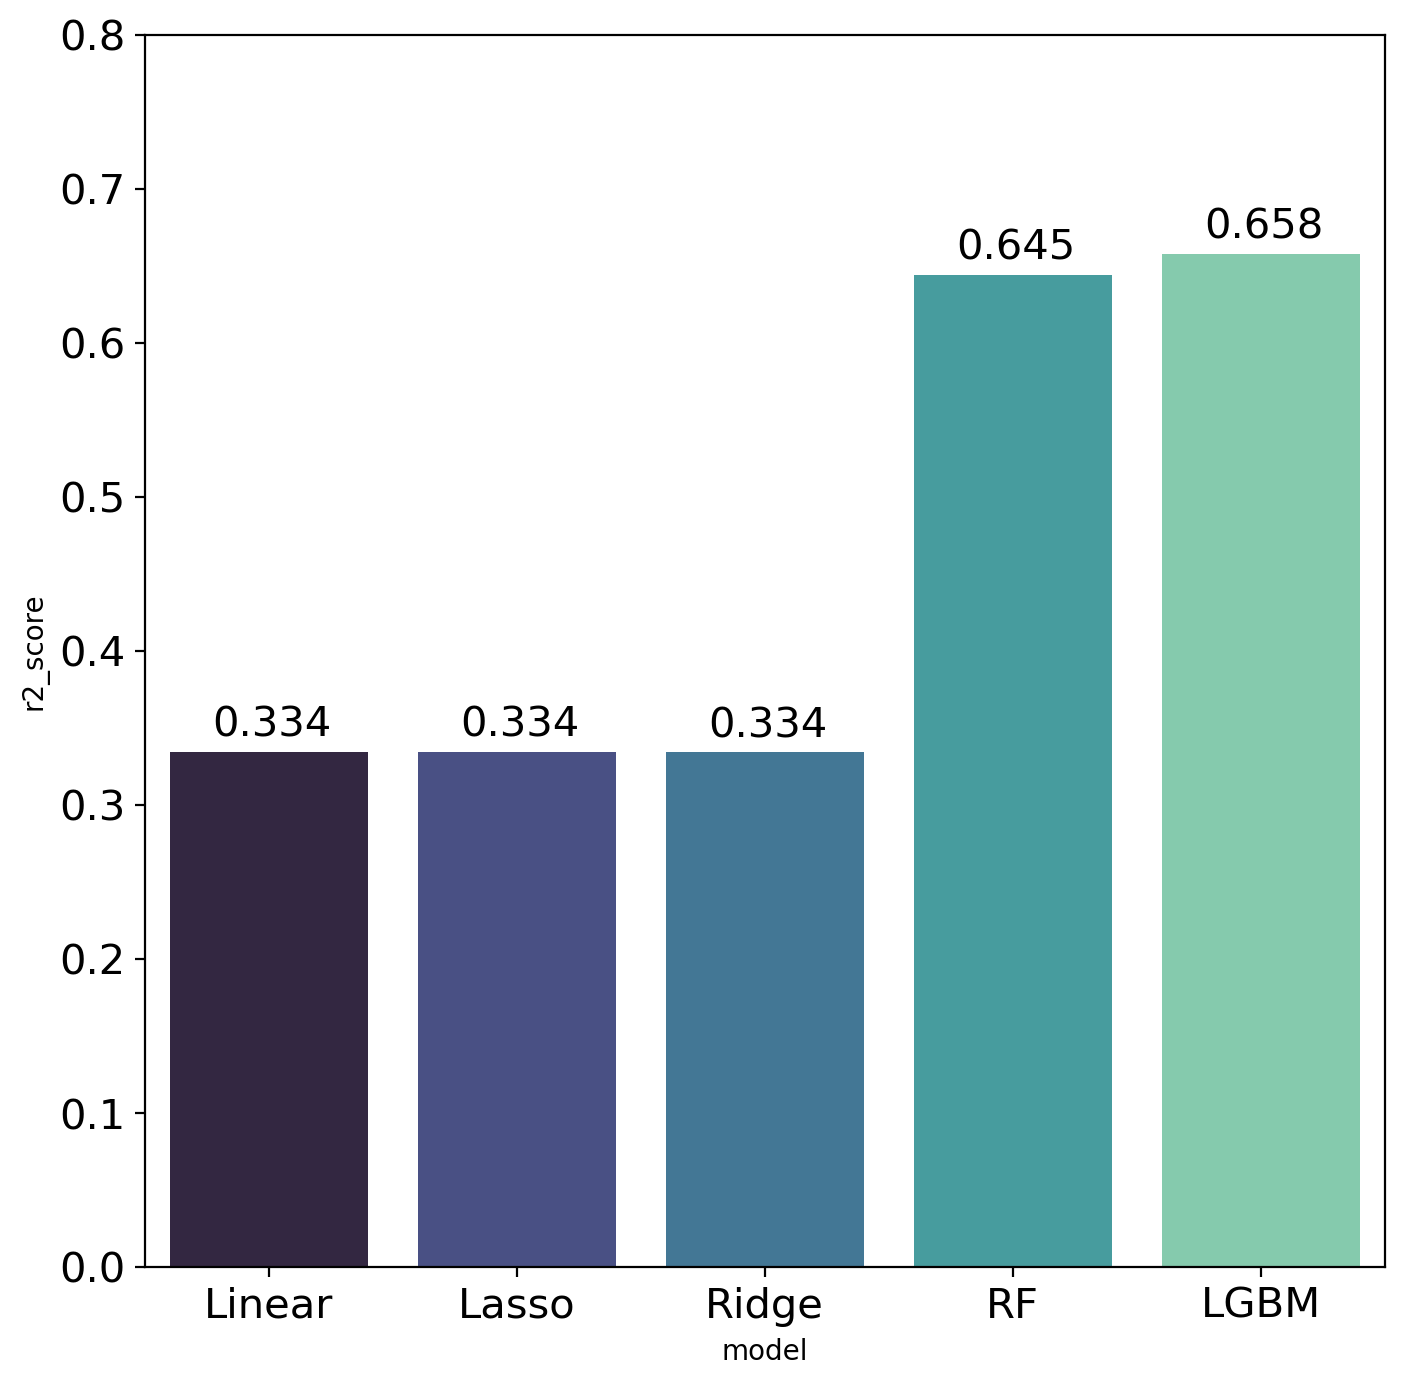

In [38]:
# campare model score

r2_scores = [r2_base,r2_lasso,r2_ridge,r2_rf,r2_lgb]
models = ["Linear","Lasso", "Ridge", "RF", "LGBM"]
df_score = pd.DataFrame({"model" : models,"r2_score" : r2_scores})
df_score
print(r2_scores)
plt.close("all")
plt.figure(figsize=(8,8), dpi=200)
plt.ylim([0,0.8])

sns.barplot(data=df_score, x="model",y="r2_score", palette="mako")
# print(plt.xticks())
for i in range(len(r2_scores)):
    plt.text(x=i-0.23 ,y=r2_scores[i]+0.01, s=r2_scores[i].round(3),fontdict={"fontsize": 15})

In [40]:
# light GBM

params = {
    "lgbmregressor__max_depth":        hp.quniform("max_depth", 30, 50, 2),
    "lgbmregressor__num_leaves":       hp.quniform("num_leaves", 40, 80, 5),
    "lgbmregressor__learning_rate":    hp.quniform("learning_rate", 0.1, 0.2, 0.01),
    "lgbmregressor__subsample":        hp.quniform("subsample", 0.5, 1.0, 0.1),
    "lgbmregressor__colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.6),
    "lgbmregressor__n_estimators":     hp.quniform("n_estimators", 1000, 2000, 100),
}


def get_pipe(params):
    params["lgbmregressor__max_depth"] = int(params["lgbmregressor__max_depth"])
    params["lgbmregressor__num_leaves"] = int(params["lgbmregressor__num_leaves"])
    params["lgbmregressor__n_estimators"] = int(params["lgbmregressor__n_estimators"])

    pipe = make_pipeline(
        ct,
        LGBMRegressor(
            # boosting_type='dart',
            random_state=42,
            n_jobs=-1,
            reg_alpha=0.6,
            reg_lambda=0.7,
        ),
    )
    pipe = pipe.set_params(**params)
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params)
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")
    avg_cv_score = np.mean(score)
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = Trials()

best_params = fmin(fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=20)

print("Best params : ", trials.best_trial["misc"]["vals"])
print("Best f2 : ", -trials.best_trial["result"]["loss"])


100%|██████████| 20/20 [04:09<00:00, 12.50s/trial, best loss: -0.6687995184422583]
Best params :  {'colsample_bytree': [0.5827051612374681], 'learning_rate': [0.11], 'max_depth': [38.0], 'n_estimators': [1400.0], 'num_leaves': [50.0], 'subsample': [0.7000000000000001]}
Best f2 :  0.6687995184422583


In [41]:
# fit with the best params

params_select = {
    "lgbmregressor__max_depth": best_params["max_depth"],
    "lgbmregressor__num_leaves": best_params["num_leaves"],
    "lgbmregressor__learning_rate": best_params["learning_rate"],
    "lgbmregressor__subsample": best_params["subsample"],
    "lgbmregressor__colsample_bytree": best_params["colsample_bytree"],
    "lgbmregressor__n_estimators": best_params["n_estimators"],
    # "lgbmregressor__reg_alpha": best_params["reg_alpha"],
    # "lgbmregressor__reg_lambda": best_params["reg_lambda"],
}
pipe = get_pipe(params_select)
pipe.fit(X_tt, y_tt)
pred_lgbmr = pipe.predict(X_test)
r2_lgbmr = r2_score(y_true=y_test,y_pred=pred_lgbmr)
r2_lgbmr

0.7053202158243743

[0.6445263338906733, 0.658029652268295, 0.7053202158243743]


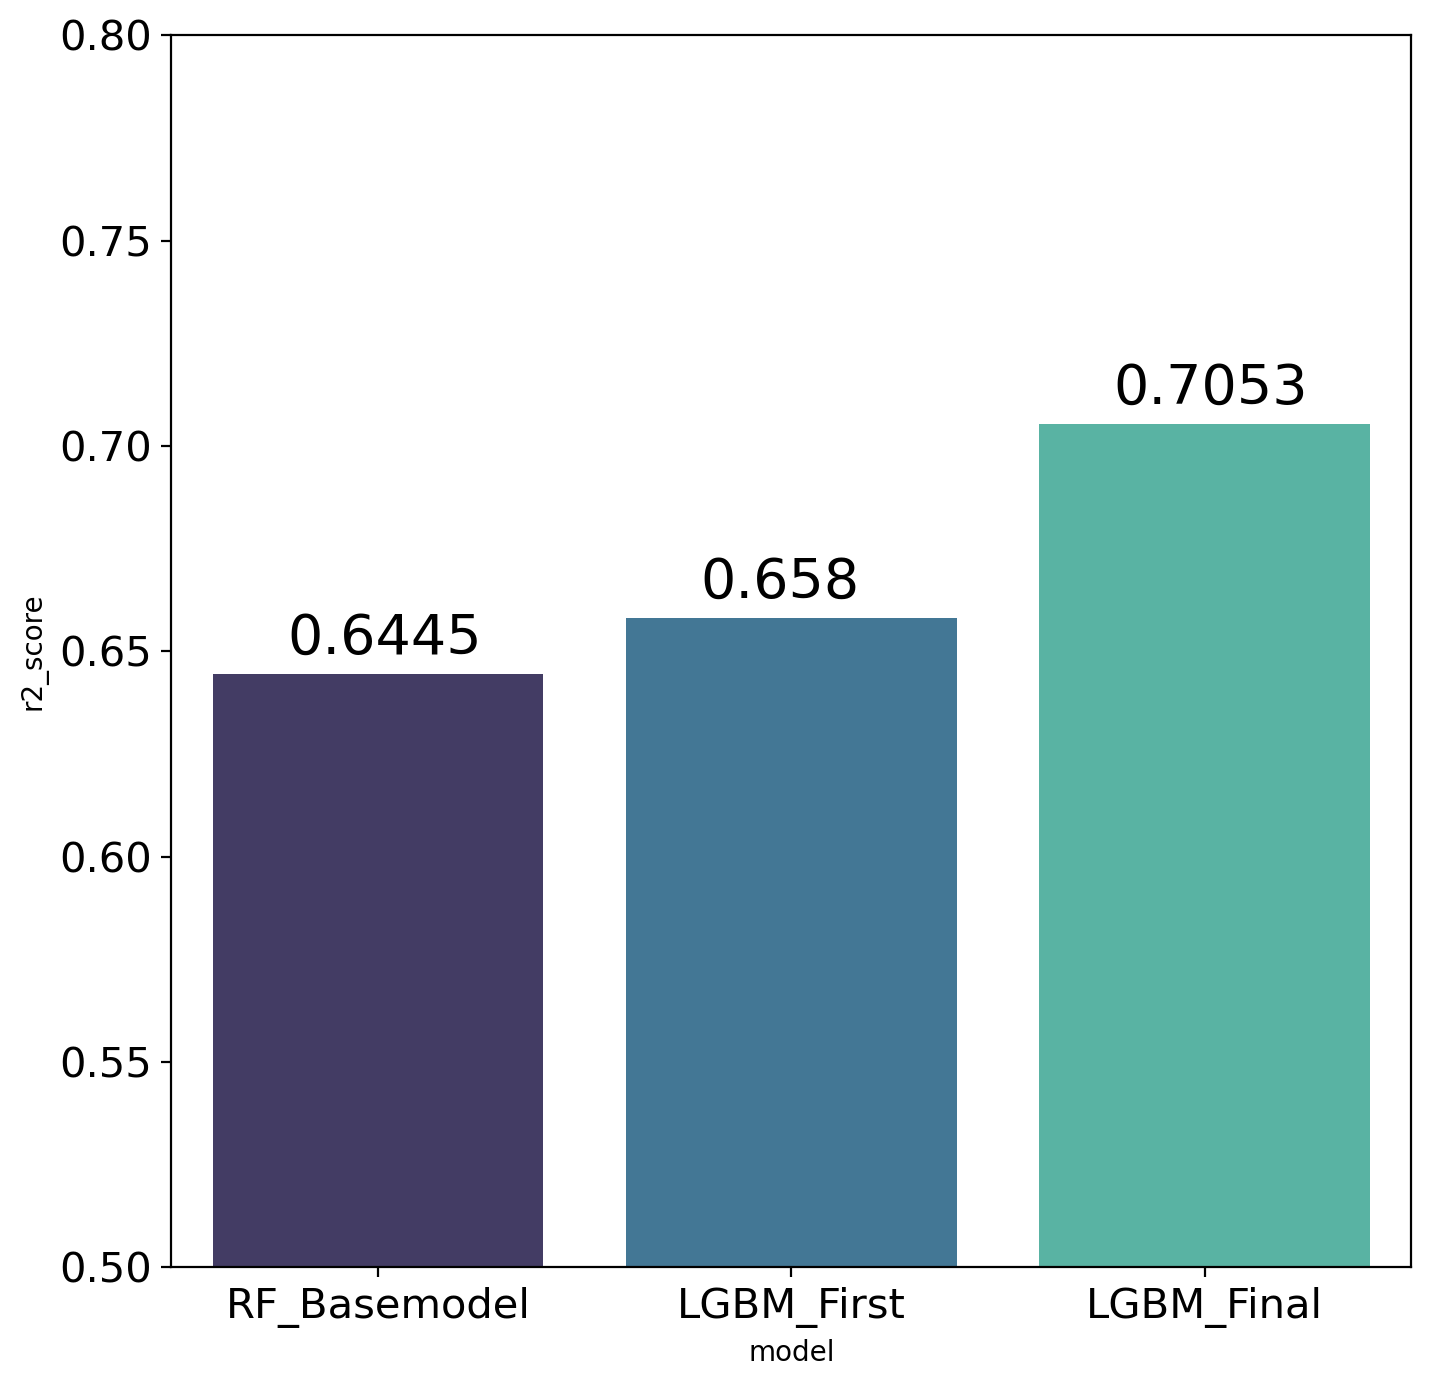

In [42]:
r2_scores = [r2_rf,r2_lgb,r2_lgbmr]
models = ["RF_Basemodel", "LGBM_First","LGBM_Final"]
df_score = pd.DataFrame({"model" : models,"r2_score" : r2_scores})
df_score
print(r2_scores)
plt.close("all")
plt.figure(figsize=(8,8), dpi=200)
plt.ylim([0.5,0.8])

sns.barplot(data=df_score, x="model",y="r2_score", palette="mako")
# print(plt.xticks())
for i in range(len(r2_scores)):
    plt.text(x=i-0.22 ,y=r2_scores[i]+0.005, s=r2_scores[i].round(4),fontdict={"fontsize": 20})

C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\3038914807.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([format(int(x),',') for x in current_values])


[Text(0.0, 0, '0'),
 Text(2000.0, 0, '2,000'),
 Text(4000.0, 0, '4,000'),
 Text(6000.0, 0, '6,000'),
 Text(8000.0, 0, '8,000'),
 Text(10000.0, 0, '10,000'),
 Text(12000.0, 0, '12,000'),
 Text(14000.0, 0, '14,000'),
 Text(16000.0, 0, '16,000')]

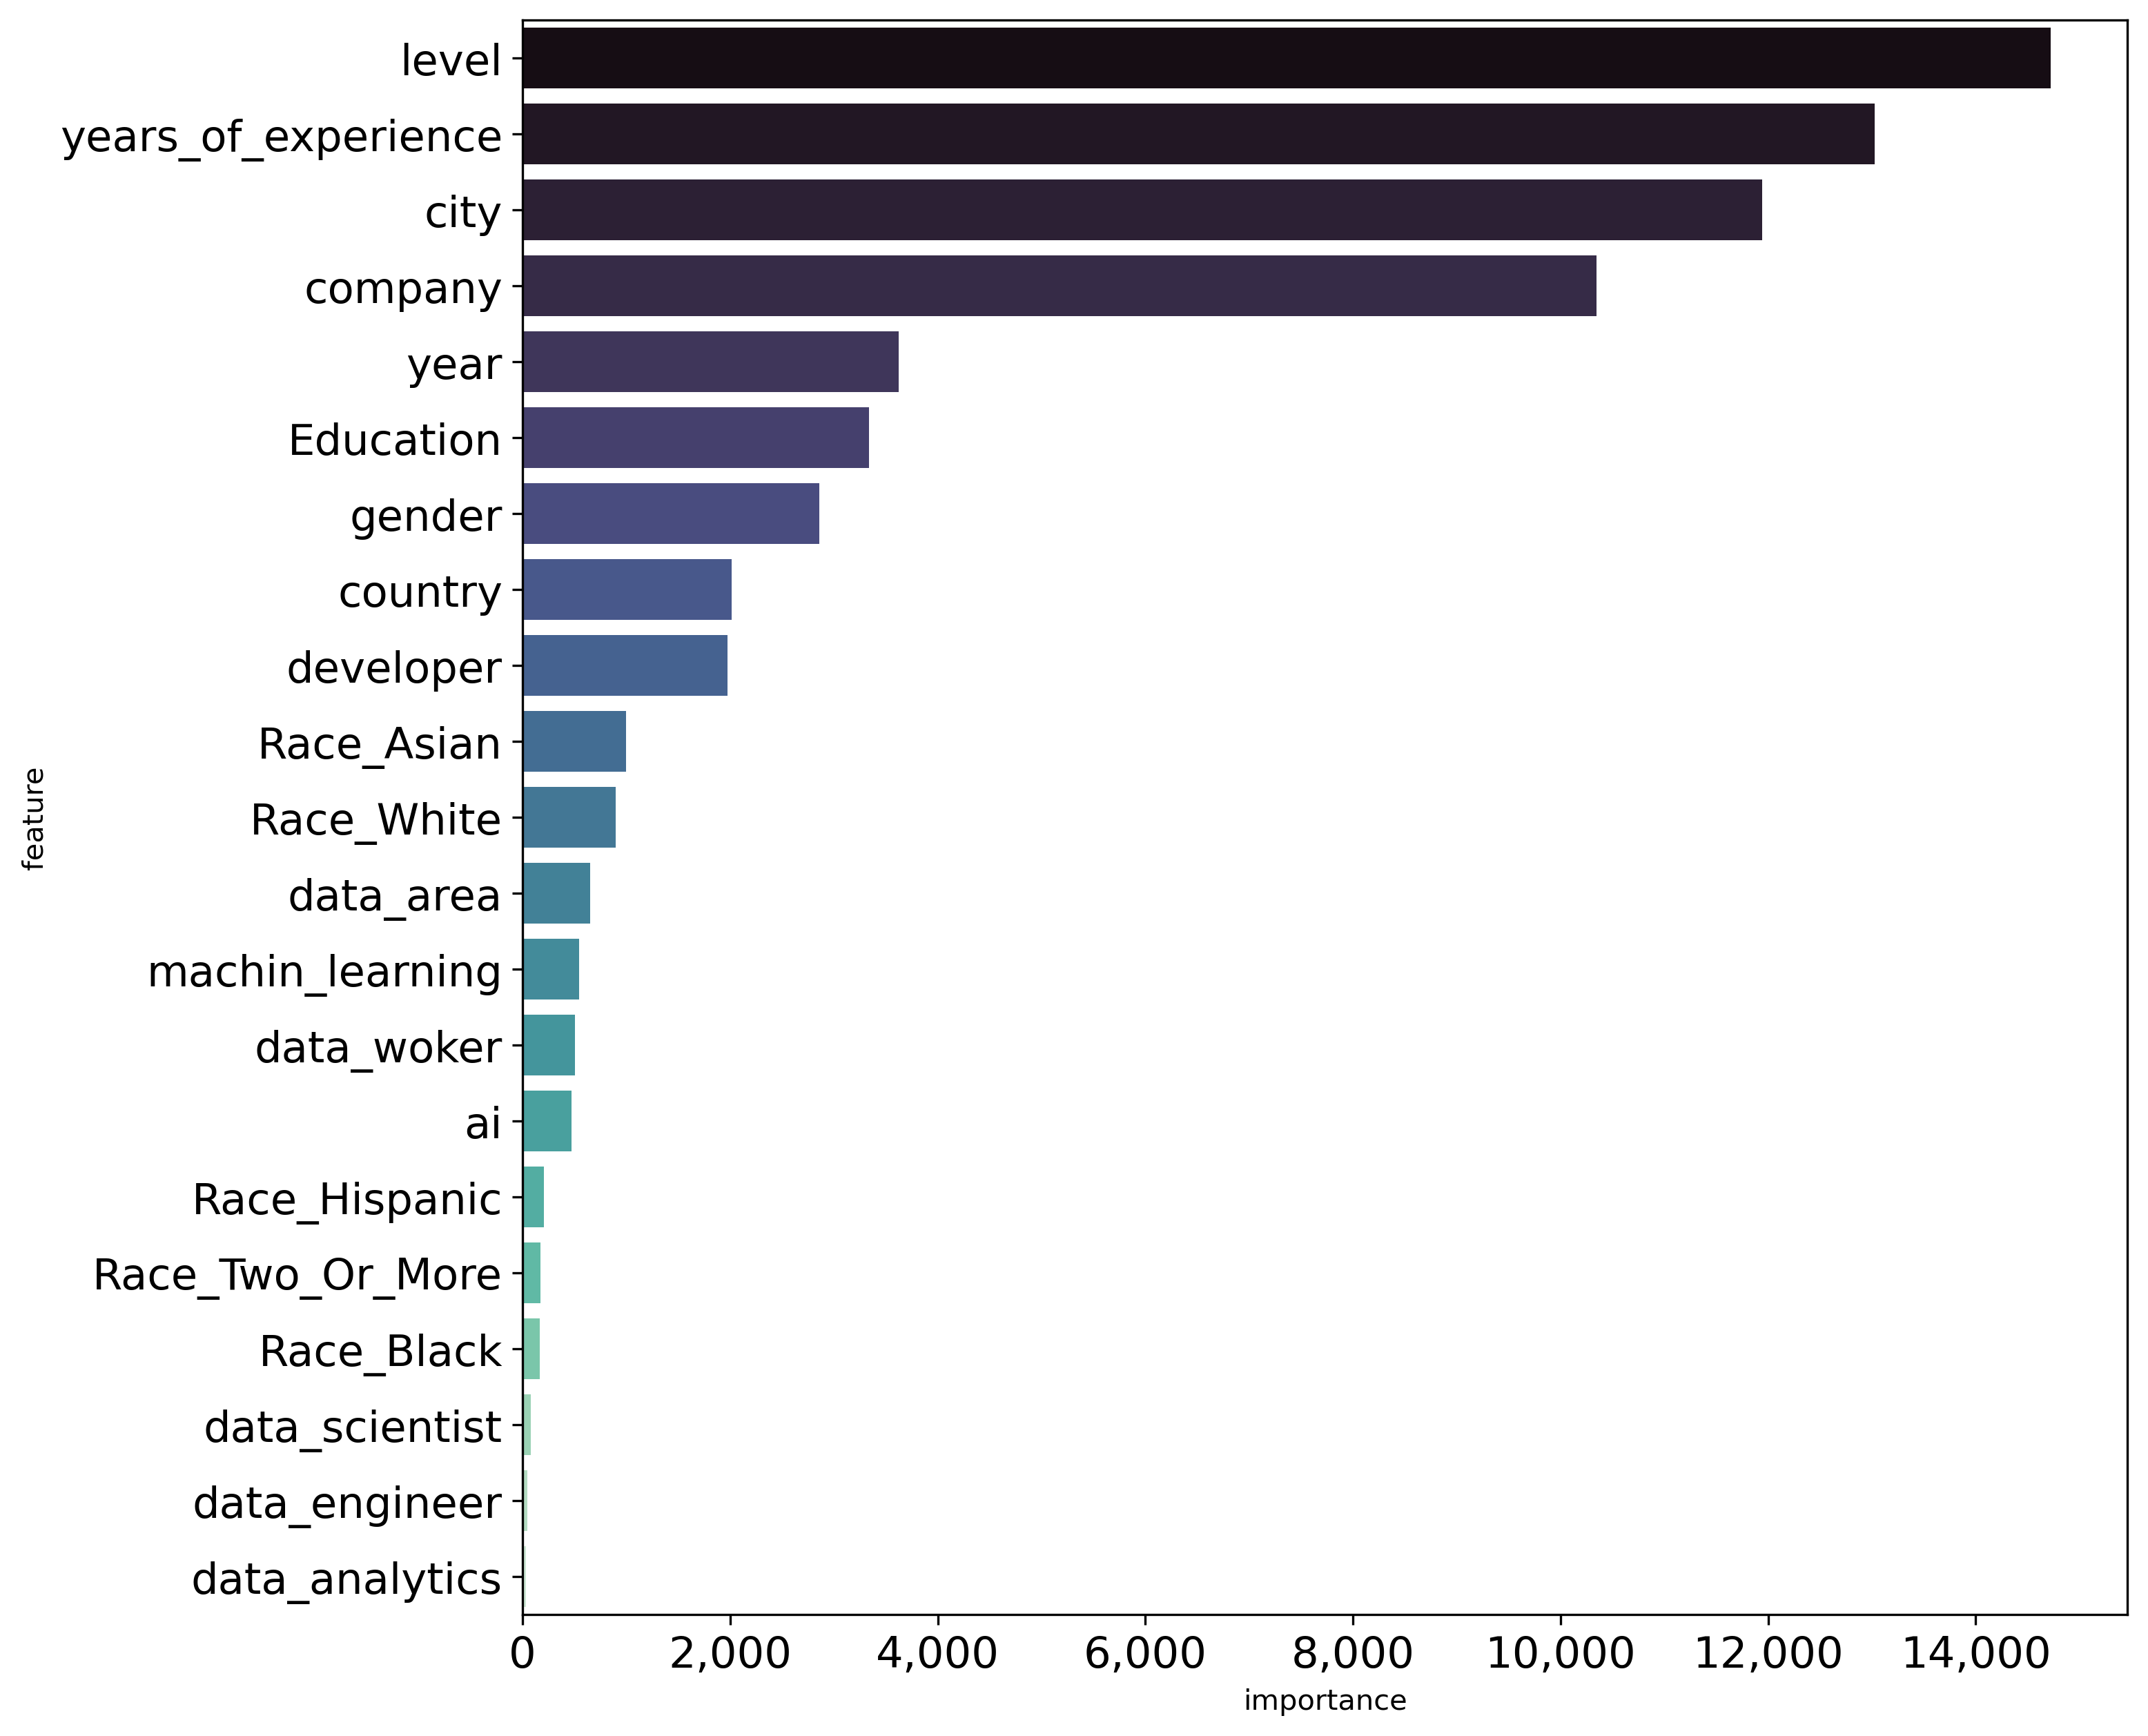

In [43]:
# 얼마나 많이 사용되었는가.

df_importance = pd.DataFrame({"feature" : pipe.feature_names_in_, "importance" : pipe[1].feature_importances_})
df_importance = df_importance.sort_values(by="importance", ascending=False)
df_importance

plt.close("all")
plt.figure(figsize=(10,10), dpi=300)

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
palette = "mako"

sns.barplot(data=df_importance,x="importance",y="feature", orient="h", palette=palette)

# put comma
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([format(int(x),',') for x in current_values])

range(0, 26)


Text(0.5, 0, 'years of experience')

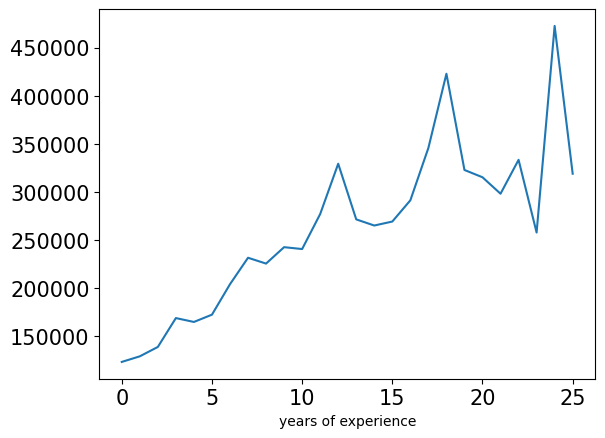

In [47]:
# ice plot test
one_datapoint = X_tt.iloc[[7]].copy()
feature_target = "years_of_experience"

feature_range = range(int(X_tt[feature_target].min()),int(X_tt[feature_target].max() + 1))

print(feature_range)
results = []

for year in feature_range:
    one_datapoint[feature_target] = year
    one_dataponit_pred = pipe.predict(one_datapoint)
    results.append(one_dataponit_pred.item())

results = np.array(results)
# results -= results[0]
plt.plot(feature_range, results)
plt.xlabel("years of experience")

In [48]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []
    
    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred = pipe.predict(one_datapoint)
        results.append(one_datapoint_pred.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

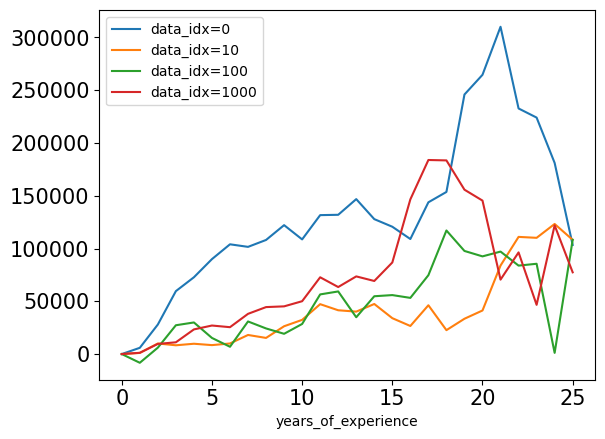

In [49]:
for data_index in [0,10,100,1000]:
    plt.plot(
        *get_ice_plot_data(
            X_test, data_index, feature_target, feature_range
        ),
        label=f"data_idx={data_index}",
    )

plt.xlabel(feature_target)
plt.legend()

In [51]:
company_Netflix = ord_enc.category_mapping[0]["mapping"]["Netflix"]
level_E3 = ord_enc.category_mapping[6]["mapping"]["E3"]
level_E4 = ord_enc.category_mapping[6]["mapping"]["E4"]
level_E5 = ord_enc.category_mapping[6]["mapping"]["E5"]
level_E6 = ord_enc.category_mapping[6]["mapping"]["E6"]
level_E7 = ord_enc.category_mapping[6]["mapping"]["E7"]
title_DS = ord_enc.category_mapping[1]["mapping"]["Data Scientist"]
gender_Male = ord_enc.category_mapping[2]["mapping"]["Male"]
country_Korea = ord_enc.category_mapping[3]["mapping"]["Korea, South"]
country_US = ord_enc.category_mapping[3]["mapping"]["U.S."]
city_Seoul = ord_enc.category_mapping[5]["mapping"]["Seoul"]
city_Los_Gatos = ord_enc.category_mapping[5]["mapping"]["Los Gatos"]

In [52]:
# predict my salary

X_me = pd.DataFrame()
me = pd.DataFrame(
    {
        "company": company_Netflix,
        "level": level_E3,
        "years_of_experience" : 0,
        "gender" : gender_Male,
        'Race_Asian' : 1,
        'Race_White' : 0, 
        'Race_Two_Or_More':0, 
        'Race_Black': 0, 
        'Race_Hispanic':0,
        'Education': 2, 
        'year' : 2021, 
        'developer': 1, 
        'data_woker': 1, 
        'machin_learning': 1, 
        'ai': 1,
        'data_analytics': 1, 
        'data_scientist': 0, 
        'data_engineer': 1, 
        'data_area': 1,
        'city' : city_Seoul, 
        'country': country_Korea,
    },
    index = [0]
)
X_me = X_me.append(me.loc[0])
X_me = X_me.append(me.loc[0])
X_me = X_me.append(me.loc[0])
X_me = X_me.append(me.loc[0])
X_me = X_me.append(me.loc[0]).reset_index(drop=True)
X_me.loc[:,"level"] = [level_E3, level_E4, level_E5, level_E6, level_E7]
# X_me.loc[:,"Education"] = [0,1,2,3,4,5]
X_me


C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\3086008723.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_me = X_me.append(me.loc[0])
C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\3086008723.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_me = X_me.append(me.loc[0])
C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\3086008723.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_me = X_me.append(me.loc[0])
C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\3086008723.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_me = X_me.append(me.loc[0])
C:\Users\TESB\AppData\Local\Temp\ipykernel_10032\3086008723.py:34: Futur

,company,level,years_of_experience,gender,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Education,...,developer,data_woker,machin_learning,ai,data_analytics,data_scientist,data_engineer,data_area,city,country
0,11,14,0,2,1,0,0,0,0,2,...,1,1,1,1,1,0,1,1,319,17
1,11,31,0,2,1,0,0,0,0,2,...,1,1,1,1,1,0,1,1,319,17
2,11,44,0,2,1,0,0,0,0,2,...,1,1,1,1,1,0,1,1,319,17
3,11,42,0,2,1,0,0,0,0,2,...,1,1,1,1,1,0,1,1,319,17
4,11,223,0,2,1,0,0,0,0,2,...,1,1,1,1,1,0,1,1,319,17


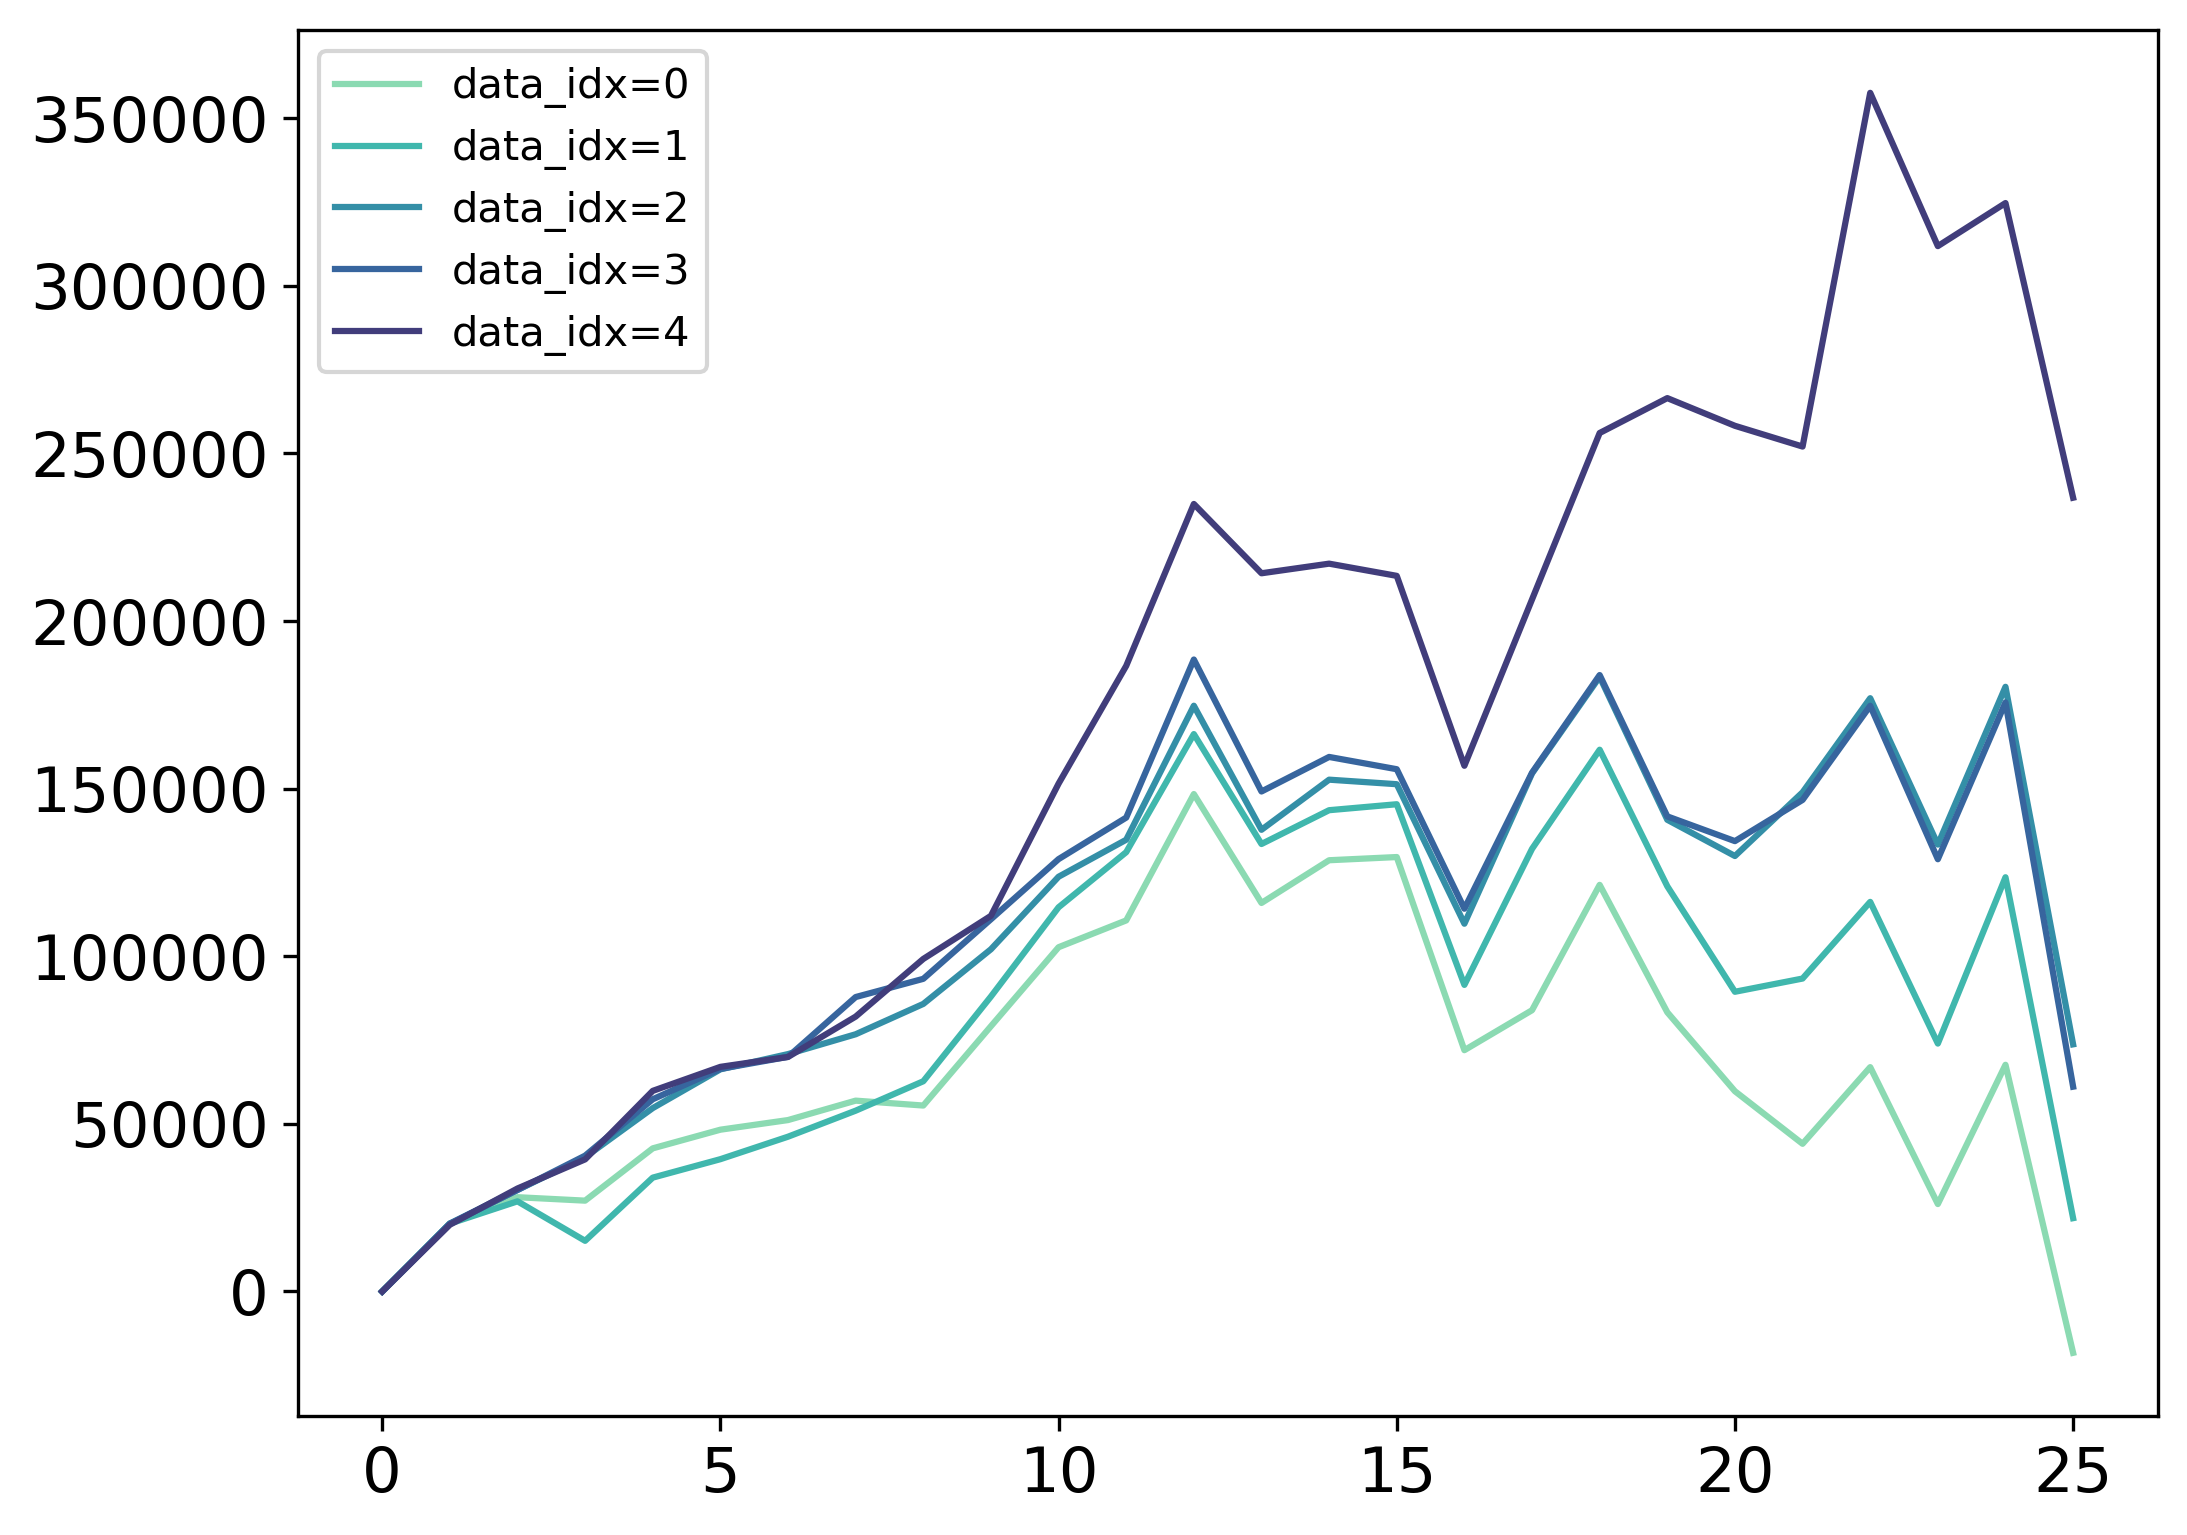

In [53]:
plt.close("all")
plt.figure(figsize=(8,6), dpi=300)
colors = sns.color_palette("mako",6)
for data_index in [0,1,2,3,4]:
    plt.plot(
        *get_ice_plot_data(
            X_me, data_index, feature_target, feature_range,
        ),
        label=f"data_idx={data_index}",
        color=colors[5-data_index],
    )

# plt.hlines(y=70007.42,xmin=0,xmax=25,colors='r',linestyles="--")
plt.legend()
# sns.lineplot(data=X_tt, x="years_of_experience",y=y_tt, palette="mako")
# plt.xlabel(feature_target)
# plt.legend()

<AxesSubplot:ylabel='annual_income'>

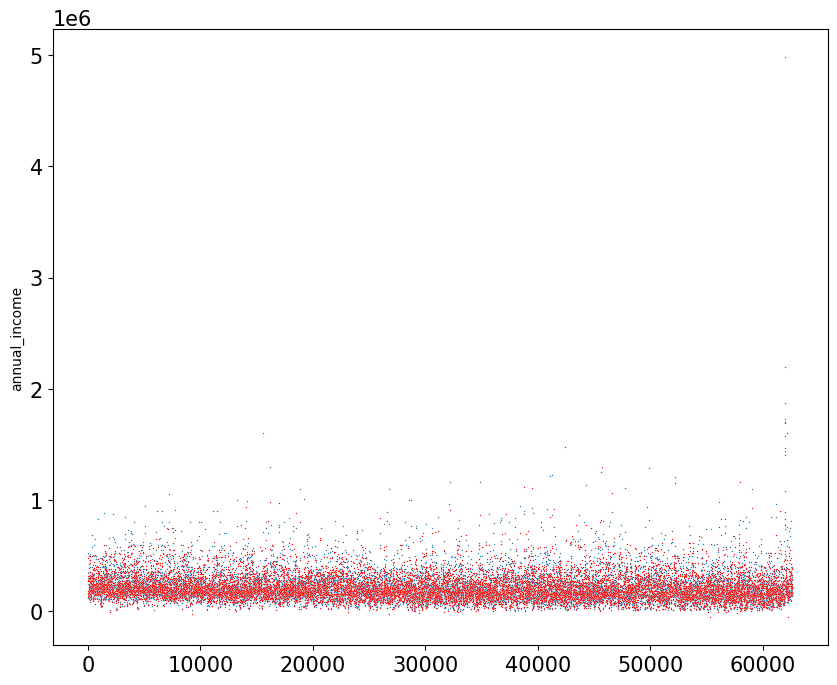

In [54]:
# prediction scatter plot

plt.close("all")
plt.figure(figsize=(10,8))
sns.scatterplot(data=X_test,x=X_test.index,y=y_test,s=1)
# sns.scatterplot(data=X_test,x=X_test.index,y=baseline,s=1,color="red")
# sns.scatterplot(data=X_test,x=X_test.index,y=pred_rf,s=1,color="green")
sns.scatterplot(data=X_test,x=X_test.index,y=pred_lgbmr,s=1,color="red")
# plt.scatter(x=X_test.index,y=y_test)